In [1]:
import warnings

In [2]:
warnings.filterwarnings("ignore", message='Glyph 150 missing from current font.')

# Imports

In [3]:
import pandas as pd
import numpy as np
from unidecode import unidecode
import matplotlib.pyplot as plt

pd.options.display.max_columns = 999
%matplotlib inline

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier

import joblib

# Downloads

In [5]:
base_2018_raw = pd.read_csv('../data/raw/microdados_perfil_discente_2018.csv',engine='python',delimiter=';',encoding='latin')

In [6]:
base_2018_raw.shape

(9929, 323)

In [7]:
base_2018_raw['Qual é o seu CR-'].isnull().value_counts()

False    8569
True     1360
Name: Qual é o seu CR-, dtype: int64

In [8]:
original_columns = list(base_2018_raw.columns)
original_columns

['Qual é o seu ano de ingresso na UFABC-',
 'Como você conheceu a UFABC (escolha o primeiro contato)-',
 'Qual foi o principal motivo de sua escolha pela UFABC-',
 'Você frequentou algum cursinho pré-vestibular-',
 'Qual é o nível de escolaridade de seu pai-',
 'Qual é o nível de escolaridade de sua mãe-',
 'Qual foi a sua forma de ingresso na UFABC-\xa0 [Ampla concorrência]',
 'Qual foi a sua forma de ingresso na UFABC-\xa0 [PEC-G/Transferência Ex Officio/Decisão Judicial]',
 'Qual foi a sua forma de ingresso na UFABC-\xa0 [Reserva de vagas (autodeclarado preto, pardo ou indígena)]',
 'Qual foi a sua forma de ingresso na UFABC-\xa0 [Reserva de vagas (cursado integralmente o ensino médio em escolas públicas)]',
 'Qual foi a sua forma de ingresso na UFABC-\xa0 [Reserva de vagas (pessoa com deficiência)]',
 'Qual foi a sua forma de ingresso na UFABC-\xa0 [Reserva de vagas (refugiado ou solicitante de refúgio - incluindo situação de vulnerabilidade econômica)]',
 'Qual foi a sua forma de 

## Renames and Casting

### Columns renaming

In [9]:
col_rename = {
    'Qual é o seu ano de ingresso na UFABC-':'ano_ingresso',
    'Como você conheceu a UFABC (escolha o primeiro contato)-':'como_conheceu',
    'Qual foi o principal motivo de sua escolha pela UFABC-':'motivo_escolha',
    'Você frequentou algum cursinho pré-vestibular-':'frequentou_cursinho',
    'Qual é o nível de escolaridade de seu pai-':'escolaridade_pai',
    'Qual é o nível de escolaridade de sua mãe-':'escolaridade_mae',
    'Qual é a sua idade-':'idade',
    'Qual é o seu estado civil-':'estado_civil',
    'Qual é o seu sexo biológico (de nascimento)-':'sexo_biologico',
    'Qual é a sua identidade de gênero-':'identidade_genero',
    'Qual é a sua orientação sexual-':'orientacao_sexual',
    'Como você classifica sua cor/raça-':'cor/raca',
    'Onde você reside atualmente-':'onde_reside',
    'Em qual região da cidade de São Paulo você reside-':'regiao_sp_reside',
    'Quantos filhos você tem-':'nmr_filhos',
    'Qual é o tempo médio necessário, em minutos, para você comparecer à UFABC-':'tempo_medio_chegada_na_ufabc',
    'Você é fumante-':'fumante',
    'Você consome bebidas alcoólicas-':'consome_bebidas_alcoolicas',
    'Você consome substâncias psicoativas-':'consome_subst_psicoativas',
    'Em qual dieta alimentar você se enquadra-':'dieta_alimentar',
    'Qual é a sua religião-':'religiao',
    'No atual quadrimestre letivo, você cursa disciplinas em qual(is) campus(i)-\xa0':'campus_atual',
    'No atual quadrimestre letivo, em qual turno você frequenta a maioria das disciplinas-\xa0':'turno',
    'Em qual Bacharelado Interdisciplinar você está matriculado(a) atualmente-':'bacharel_interdisciplinar',
    'Você pretende solicitar transferência para outro Bacharelado Interdisciplinar da UFABC no\r\npróximo ano acadêmico-\xa0':'deseja_solicitar_transf_interna',
    'Você já foi reprovado em alguma disciplina-\xa0':'possui_reprovacoes',
    'Você já efetuou trancamento total de matrícula-':'trancamento_matricula',
    'Você participa/participou de programa(s) de mobilidade acadêmica-':'mobilidade_academica',
    'Qual é o seu CR-':'CR',
    'Qual é o seu CA-':'CA',
    'Quantas horas, em média, você permanece na UFABC por semana-':'horas_semanais_na_ufabc',
    'Você possui a intenção de iniciar um curso de pós graduação stricto sensu (mestrado ou doutorado) logo após a sua graduação-':'pretende_pos_grad',
    'Qual é a renda média bruta\xa0mensal de sua família-':'renda_familiar_mensal',
    'Quantidade de pessoas, incluindo você, que vivem da renda média bruta mensal familiar-\xa0':'qtd_pessoas_familia',
    'Qual é a sua principal fonte de sustento-\xa0':'fonte_de_sustento',
    'Qual é, em média, a quantidade de dinheiro que você recebe mensalmente-':'salario_mensal',
    'Você exerce alguma atividade remunerada (não acadêmica)-':'atividade_remunerada',
    'Qual é o tipo de vínculo da sua atividade remunerada (não acadêmica)-':'tipo_de_vinculo_atividade_remunerada',
    'Em que setor você atua-':'setor',
    'Qual é o seu tipo de moradia-':'tipo_moradia',
    'Com que frequência você utiliza o restaurante universitário-':'frequencia_ru',
    'Qual é o valor médio aproximado que você utiliza por dia para se alimentar durante sua permanência na UFABC-\xa0':'valor_gasto_alimentacao_interna',
    'De 1 (péssimo/não atende) a 5 (excelente/atende plenamente) avalie este questionário: [Avaliação]':'nota_questionario'
}

In [10]:
base_2018 = base_2018_raw.rename(columns=col_rename)

In [11]:
multipla_escolha = []
last_print=''
for c in base_2018.columns:
    if "[" in c:
        if(c.split("[")[0]!=last_print):
            multipla_escolha.append(c.split("[")[0])
            last_print=c.split("[")[0]
multipla_escolha

['Qual foi a sua forma de ingresso na UFABC-\xa0 ',
 'Qual(is) é(são) o(s) principal(is) meio(s) de transporte que você geralmente utiliza para chegar à UFABC- ',
 'De quais atividades extraclasse relacionadas à UFABC você participa- ',
 'Qual é o seu nível de conhecimento nos seguintes idiomas- ',
 'Qual(is) dificuldade(s) tem(têm) interferido significativamente na sua vida acadêmica em 2018- ',
 'Qual(is) dificuldade(s) emocional(is) tem(têm) interferido significativamente na sua vida acadêmica em 2018- ',
 'Você já sofreu preconceito ou discriminação nas dependências da UFABC- ',
 'Você já sofreu algum tipo de assédio nas dependências da UFABC- ',
 'Você possui alguma doença crônica- ',
 'Você é favorável a qual(is) política(s) de cota(s)- ',
 'Do seu ponto de vista, em relação à diversidade na UFABC: ',
 'Em qual(is) curso(s) pós-BC&T você pretende se matricular- ',
 'Em qual(is) curso(s) pós-BC&T você atualmente está matriculado- ',
 'Em qual(is) curso(s) pós-BC&H você pretende se

In [12]:
conversao_multipla_escolha = {
    'Qual foi a sua forma de ingresso na UFABC-\xa0 ':'forma_ingresso',
    'Qual(is) é(são) o(s) principal(is) meio(s) de transporte que você geralmente utiliza para chegar à UFABC- ':'meio_transporte',
    'De quais atividades extraclasse relacionadas à UFABC você participa- ':'atividade_extraclasse',
    'Qual é o seu nível de conhecimento nos seguintes idiomas- ':'nivel_conhecimento_idioma',
    'Qual(is) dificuldade(s) tem(têm) interferido significativamente na sua vida acadêmica em 2018- ':'dificuldades',
    'Qual(is) dificuldade(s) emocional(is) tem(têm) interferido significativamente na sua vida acadêmica em 2018- ':'dificuldades_emocionais',
    'Você já sofreu preconceito ou discriminação nas dependências da UFABC- ':'preconceito_discriminacao',
    'Você já sofreu algum tipo de assédio nas dependências da UFABC- ':'assedio',
    'Você possui alguma doença crônica- ':'doenca_cronica',
    'Você é favorável a qual(is) política(s) de cota(s)- ':'favoravel_cotas',
    'Do seu ponto de vista, em relação à diversidade na UFABC: ':'pdv_diversidade',
    'Em qual(is) curso(s) pós-BC&T você pretende se matricular- ':'pos-bct_pretende',
    'Em qual(is) curso(s) pós-BC&T você atualmente está matriculado- ':'pos-bct_matriculado',
    'Em qual(is) curso(s) pós-BC&H você pretende se matricular- ':'pos-bch_pretende',
    'Em qual(is) curso(s) pós-BC&H você atualmente está matriculado- ':'pos-bch_matriculado',
    'Por qual(is) motivo(s) você efetuou trancamento total de matrícula- ':'motivo_trancamento_matricula',
    'De quais programas de desenvolvimento acadêmico você participa/participou em 2018- ':'programa_desenv_acad',
    'Qual(is) é(são) o(s) seu(s) principal(is) objetivo(s) após a conclusão dos seus estudos na UFABC- ':'obj_pos_conclusao',
    'De 1 (péssimo/não atende) a 5 (excelente/atende plenamente) avalie a infraestrutura\r\nda UFABC (campus Santo André):\xa0 ':'nota_infraestrutura_sa',
    'De 1 (péssimo/não atende) a 5 (excelente/atende plenamente) avalie a infraestrutura da UFABC (campus São Bernardo):\xa0 ':'nota_infraestrutura_sbc',
    'De 1 (péssimo/não atende) a 5 (excelente/atende plenamente)\xa0avalie os seguintes aspectos da UFABC: ':'nota',
    'Quem é(são) o(os) principal(is) mantenedor(es) de sua família- ':'principal_mantedor_familia',
    'De quais programas de assistência estudantil você participa-\xa0 ':'programa_assist_estudantil'
}
renames_multipla_escolha = {}
for c in base_2018.columns:
    if(c.split("[")[0] in list(conversao_multipla_escolha.keys())):
        renames_multipla_escolha[c]= c.replace(c.split("[")[0],conversao_multipla_escolha[c.split("[")[0]]+' ')

In [13]:
base_2018 = base_2018.rename(columns=renames_multipla_escolha)

In [14]:
print('*****************************************************************')
n_numeric = []
for item in base_2018.dtypes.to_dict().items():
    if(("int" not in str(item[1])) & ("float" not in str(item[1]))):
           n_numeric.append(item)

print('Colunas não numericas:'+str(len(n_numeric))+"\n")
for c in n_numeric:
    print(c)
print('*****************************************************************')

*****************************************************************
Colunas não numericas:322

('ano_ingresso', dtype('O'))
('como_conheceu', dtype('O'))
('motivo_escolha', dtype('O'))
('frequentou_cursinho', dtype('O'))
('escolaridade_pai', dtype('O'))
('escolaridade_mae', dtype('O'))
('forma_ingresso [Ampla concorrência]', dtype('O'))
('forma_ingresso [PEC-G/Transferência Ex Officio/Decisão Judicial]', dtype('O'))
('forma_ingresso [Reserva de vagas (autodeclarado preto, pardo ou indígena)]', dtype('O'))
('forma_ingresso [Reserva de vagas (cursado integralmente o ensino médio em escolas públicas)]', dtype('O'))
('forma_ingresso [Reserva de vagas (pessoa com deficiência)]', dtype('O'))
('forma_ingresso [Reserva de vagas (refugiado ou solicitante de refúgio - incluindo situação de vulnerabilidade econômica)]', dtype('O'))
('forma_ingresso [Reserva de vagas (renda familiar bruta per capita igual ou inferior a 1,5 salário mínimo)]', dtype('O'))
('forma_ingresso [Transferência externa]', dty

### Value translating

In [15]:
base_2018 = base_2018.replace('Sim',1)
base_2018 = base_2018.replace('sim',1)
base_2018 = base_2018.replace('Não',0)
base_2018 = base_2018.replace('não',0)
base_2018 = base_2018.replace('Nao',0)
base_2018 = base_2018.replace('nao',0)
base_2018 = base_2018.replace('Prefiro não responder',-1)
base_2018 = base_2018.replace('Não tenho filhos',0)
base_2018 = base_2018.replace('3 ou mais',3)
base_2018 = base_2018.replace('Não tenho condições de opinar sobre este item',0)
base_2018 = base_2018.replace('Não sei opinar',-2)

In [16]:
base_2018.head()

,ano_ingresso,como_conheceu,motivo_escolha,frequentou_cursinho,escolaridade_pai,escolaridade_mae,forma_ingresso [Ampla concorrência],forma_ingresso [PEC-G/Transferência Ex Officio/Decisão Judicial],"forma_ingresso [Reserva de vagas (autodeclarado preto, pardo ou indígena)]",forma_ingresso [Reserva de vagas (cursado integralmente o ensino médio em escolas públicas)],forma_ingresso [Reserva de vagas (pessoa com deficiência)],forma_ingresso [Reserva de vagas (refugiado ou solicitante de refúgio - incluindo situação de vulnerabilidade econômica)],"forma_ingresso [Reserva de vagas (renda familiar bruta per capita igual ou inferior a 1,5 salário mínimo)]",forma_ingresso [Transferência externa],forma_ingresso [Prefiro não responder],idade,estado_civil,sexo_biologico,identidade_genero,orientacao_sexual,cor/raca,onde_reside,regiao_sp_reside,nmr_filhos,meio_transporte [Caminhando (percurso total)],meio_transporte [Caminhando (parte do percurso)],meio_transporte [Bicicleta],meio_transporte [Carona],meio_transporte [Fretado/van],meio_transporte [Metrô],meio_transporte [Ônibus da UFABC],meio_transporte [Transporte particular (carro)],meio_transporte [Transporte particular (moto)],meio_transporte [Uber/taxi],meio_transporte [Trem],meio_transporte [Trólebus/ônibus - exceto ônibus da UFABC],meio_transporte [Prefiro não responder],tempo_medio_chegada_na_ufabc,atividade_extraclasse [Não participo de atividades extraclasse relacionadas à UFABC],atividade_extraclasse [AIESEC],atividade_extraclasse [Atividades culturais],atividade_extraclasse [Atividades de extensão],atividade_extraclasse [Atividades esportivas],atividade_extraclasse [AXIS  Atlética UFABC/CAAP],atividade_extraclasse [Coletivos de cunho religioso],atividade_extraclasse [Coletivos relacionados ao ativismo político],atividade_extraclasse [Coletivos relacionados ao empreendedorismo],atividade_extraclasse [Cursos de idiomas],atividade_extraclasse [DCE/Diretório Acadêmico/Centros Acadêmicos.],atividade_extraclasse [Empresas júniores],atividade_extraclasse [ENACTUS UFABC],atividade_extraclasse [Coletivos LGBTQ+],atividade_extraclasse [Coletivos feministas],atividade_extraclasse [Coletivos étnico-raciais],atividade_extraclasse [GPDA UFABC],atividade_extraclasse [Infanteria UFABC],atividade_extraclasse [Ramo Estudantil IEEE da UFABC],"atividade_extraclasse [Representação discente (ConsUni, ConsEPE, Comissões, etc)]",atividade_extraclasse [UFABC Cheer],atividade_extraclasse [Outras atividades extraclasse (não listadas acima)],atividade_extraclasse [Prefiro não responder],nivel_conhecimento_idioma [Alemão],nivel_conhecimento_idioma [Espanhol],nivel_conhecimento_idioma [Francês],nivel_conhecimento_idioma [Inglês],nivel_conhecimento_idioma [Italiano],nivel_conhecimento_idioma [Japonês],nivel_conhecimento_idioma [Libras],dificuldades [Nenhuma],dificuldades [Acessibilidade nas dependências da UFABC],dificuldades [Assuntos familiares/pessoais],dificuldades [Déficit de formação acadêmica básica],dificuldades [Didática dos docentes],dificuldades [Discriminações e preconceitos],dificuldades [Falta de disciplina/hábito de estudo],dificuldades [Problemas de saúde/psicológicos],dificuldades [Questões financeiras],dificuldades [Questões profissionais],dificuldades [Prefiro não responder],dificuldades_emocionais [Nenhuma],dificuldades_emocionais [Ansiedade],"dificuldades_emocionais [Desânimo, falta de vontade de fazer as coisas]",dificuldades_emocionais [Distúrbios alimentares],"dificuldades_emocionais [Ideia de morte (Pensamentos homicidas, medo da morte, etc)]",dificuldades_emocionais [Medo/pânico],dificuldades_emocionais [Pensamento suicida],dificuldades_emocionais [Sensação de desamparo/desespero/desesperança],dificuldades_emocionais [Sensação de desatenção/desorientação/confusão mental],dificuldades_emocionais [Sentimento de solidão],dificuldades_emocionais [Timidez excessiva],dificuldades_emocionais [Tristeza persistente],dificuldades_emocionais [Prefiro não responder],preconceito_discriminacao [N

In [17]:
base_2018.to_csv('../data/processed/2018_renamed.csv')

In [18]:
base_2018 = pd.read_csv('../data/processed/2018_renamed.csv',index_col=0)

### Treating column by column

In [19]:
print('*****************************************************************')
n_numeric = []
for item in base_2018.dtypes.to_dict().items():
    if(("int" not in str(item[1])) & ("float" not in str(item[1]))):
           n_numeric.append(item)

print('Colunas não numericas:'+str(len(n_numeric))+"\n")
for c in n_numeric:
    print(c)
print('*****************************************************************')

*****************************************************************
Colunas não numericas:44

('como_conheceu', dtype('O'))
('motivo_escolha', dtype('O'))
('frequentou_cursinho', dtype('O'))
('escolaridade_pai', dtype('O'))
('escolaridade_mae', dtype('O'))
('estado_civil', dtype('O'))
('sexo_biologico', dtype('O'))
('identidade_genero', dtype('O'))
('orientacao_sexual', dtype('O'))
('cor/raca', dtype('O'))
('onde_reside', dtype('O'))
('regiao_sp_reside', dtype('O'))
('tempo_medio_chegada_na_ufabc', dtype('O'))
('nivel_conhecimento_idioma [Alemão]', dtype('O'))
('nivel_conhecimento_idioma [Espanhol]', dtype('O'))
('nivel_conhecimento_idioma [Francês]', dtype('O'))
('nivel_conhecimento_idioma [Inglês]', dtype('O'))
('nivel_conhecimento_idioma [Italiano]', dtype('O'))
('nivel_conhecimento_idioma [Japonês]', dtype('O'))
('nivel_conhecimento_idioma [Libras]', dtype('O'))
('consome_bebidas_alcoolicas', dtype('O'))
('consome_subst_psicoativas', dtype('O'))
('dieta_alimentar', dtype('O'))
('reli

##### Nota: Colunas que são representadas por degrais (Ex: de A até B) serão transformada em numérica a partir do valor superior

In [20]:
base_2018['tempo_medio_chegada_na_ufabc'].value_counts()

De 60 a 120    3044
De 45 a 60     1659
Até 15         1428
De 15 a 30     1377
De 30 a 45     1309
Mais de 120     751
-1              361
Name: tempo_medio_chegada_na_ufabc, dtype: int64

In [21]:
base_2018['tempo_medio_chegada_na_ufabc'] = base_2018['tempo_medio_chegada_na_ufabc'].replace('De 60 a 120',120)
base_2018['tempo_medio_chegada_na_ufabc'] = base_2018['tempo_medio_chegada_na_ufabc'].replace('De 45 a 60',60)
base_2018['tempo_medio_chegada_na_ufabc'] = base_2018['tempo_medio_chegada_na_ufabc'].replace('Até 15',15)
base_2018['tempo_medio_chegada_na_ufabc'] = base_2018['tempo_medio_chegada_na_ufabc'].replace('De 15 a 30',30)
base_2018['tempo_medio_chegada_na_ufabc'] = base_2018['tempo_medio_chegada_na_ufabc'].replace('De 30 a 45',45)
base_2018['tempo_medio_chegada_na_ufabc'] = base_2018['tempo_medio_chegada_na_ufabc'].replace('Mais de 120',150)
base_2018['tempo_medio_chegada_na_ufabc'] = base_2018['tempo_medio_chegada_na_ufabc'].astype(int)

In [22]:
base_2018['tempo_medio_chegada_na_ufabc'].value_counts()

 120    3044
 60     1659
 15     1428
 30     1377
 45     1309
 150     751
-1       361
Name: tempo_medio_chegada_na_ufabc, dtype: int64

##### Niveis traduzidos de str para int

In [23]:
for c in base_2018.columns:
    if 'nivel_conhecimento_idioma' in c:
        base_2018[c] = base_2018[c].replace('Não possuo conhecimentos',0)
        base_2018[c] = base_2018['nivel_conhecimento_idioma [Alemão]'].replace('Básico',1)
        base_2018[c] = base_2018['nivel_conhecimento_idioma [Alemão]'].replace('Intermediário',2)
        base_2018[c] = base_2018['nivel_conhecimento_idioma [Alemão]'].replace('Avançado',3)
        base_2018[c] = base_2018['nivel_conhecimento_idioma [Alemão]'].replace('Fluente',4)
        base_2018[c] = base_2018[c].astype(int)

In [24]:
base_2018['consome_bebidas_alcoolicas'] = base_2018['consome_bebidas_alcoolicas'].replace('Sim, esporadicamente',1)
base_2018['consome_bebidas_alcoolicas'] = base_2018['consome_bebidas_alcoolicas'].replace('Sim, três vezes por semana em média',2)
base_2018['consome_bebidas_alcoolicas'] = base_2018['consome_bebidas_alcoolicas'].replace('Sim, diariamente',3)
base_2018['consome_bebidas_alcoolicas'] = base_2018['consome_bebidas_alcoolicas'].astype(int)

In [25]:
base_2018['consome_subst_psicoativas'].value_counts()

Nunca experimentei                 5498
Apenas experimentei                1900
Utilizo esporadicamente            1199
-1                                  697
Utilizo frequentemente              273
Não utilizo mais                    238
Utilizo com recomendação médica     124
Name: consome_subst_psicoativas, dtype: int64

In [26]:
base_2018['possui_reprovacoes'] = base_2018['possui_reprovacoes'].replace('Sim, sete ou mais vezes',7)
base_2018['possui_reprovacoes'] = base_2018['possui_reprovacoes'].replace('Sim, apenas uma vez',1)
base_2018['possui_reprovacoes'] = base_2018['possui_reprovacoes'].replace('Sim, duas vezes',2)
base_2018['possui_reprovacoes'] = base_2018['possui_reprovacoes'].replace('Sim, três vezes',3)
base_2018['possui_reprovacoes'] = base_2018['possui_reprovacoes'].replace('Sim, quatro vezes',4)
base_2018['possui_reprovacoes'] = base_2018['possui_reprovacoes'].replace('Sim, cinco vezes',5)
base_2018['possui_reprovacoes'] = base_2018['possui_reprovacoes'].replace('Sim, seis vezes',6)
base_2018['possui_reprovacoes'] = base_2018['possui_reprovacoes'].astype(float)

In [27]:
base_2018['frequentou_cursinho'] = base_2018['frequentou_cursinho'].replace('Sim - cursinho tradicional',2)
base_2018['frequentou_cursinho'] = base_2018['frequentou_cursinho'].replace('Sim - cursinho popular/comunitário',1)
base_2018['frequentou_cursinho'] = base_2018['frequentou_cursinho'].astype(float)

In [28]:
base_2018['trancamento_matricula'] = base_2018['trancamento_matricula'].replace('Sim, apenas uma vez',1)
base_2018['trancamento_matricula'] = base_2018['trancamento_matricula'].replace('Sim, duas vezes',2)
base_2018['trancamento_matricula'] = base_2018['trancamento_matricula'].replace('Sim, três vezes',3)
base_2018['trancamento_matricula'] = base_2018['trancamento_matricula'].replace('Sim, quatro vezes',4)
base_2018['trancamento_matricula'] = base_2018['trancamento_matricula'].replace('Sim, cinco ou mais vezes',5)
base_2018['trancamento_matricula'] = base_2018['trancamento_matricula'].astype(float)

In [29]:
base_2018['mobilidade_academica'] = base_2018['mobilidade_academica'].replace('Sim, no Brasil',1)
base_2018['mobilidade_academica'] = base_2018['mobilidade_academica'].replace('Sim, no exterior',2)
base_2018['mobilidade_academica'] = base_2018['mobilidade_academica'].replace('Sim, no Brasil e no exterior',3)
base_2018['mobilidade_academica'] = base_2018['mobilidade_academica'].astype(float)

In [30]:
base_2018['CR']=base_2018['CR'].astype(str).str.replace(',','.').astype(float)
base_2018['CA']=base_2018['CA'].astype(str).str.replace(',','.').astype(float)

In [31]:
base_2018['horas_semanais_na_ufabc'] = base_2018['horas_semanais_na_ufabc'].replace('De 16 a 20 horas',20)
base_2018['horas_semanais_na_ufabc'] = base_2018['horas_semanais_na_ufabc'].replace('De 6 a 10 horas',10)
base_2018['horas_semanais_na_ufabc'] = base_2018['horas_semanais_na_ufabc'].replace('De 21 a 25 horas',25)
base_2018['horas_semanais_na_ufabc'] = base_2018['horas_semanais_na_ufabc'].replace('De 11 a 15 horas',15)
base_2018['horas_semanais_na_ufabc'] = base_2018['horas_semanais_na_ufabc'].replace('De 26 a 30 horas',30)
base_2018['horas_semanais_na_ufabc'] = base_2018['horas_semanais_na_ufabc'].replace('Acima de 31 horas',35)
base_2018['horas_semanais_na_ufabc'] = base_2018['horas_semanais_na_ufabc'].replace('Até 5 horas',5)
base_2018['horas_semanais_na_ufabc'] = base_2018['horas_semanais_na_ufabc'].astype(float)

In [32]:
base_2018['renda_familiar_mensal'] = base_2018['renda_familiar_mensal'].replace('Acima de R$ 50.000,00',75)
base_2018['renda_familiar_mensal'] = base_2018['renda_familiar_mensal'].replace('Até R$ 1.000,00',1)
base_2018['renda_familiar_mensal'] = base_2018['renda_familiar_mensal'].replace('De R$ 1.000,01 a R$ 2.000,00',2)
base_2018['renda_familiar_mensal'] = base_2018['renda_familiar_mensal'].replace('De R$ 2.000,01 a R$ 3.000,00',3)
base_2018['renda_familiar_mensal'] = base_2018['renda_familiar_mensal'].replace('De R$ 3.000,01 a R$ 4.000,00',4)
base_2018['renda_familiar_mensal'] = base_2018['renda_familiar_mensal'].replace('De R$ 4.000,01 a R$ 5.000,00',5)
base_2018['renda_familiar_mensal'] = base_2018['renda_familiar_mensal'].replace('De R$ 5.000,01 a R$ 7.000,00',7)
base_2018['renda_familiar_mensal'] = base_2018['renda_familiar_mensal'].replace('De R$ 7.000,01 a R$ 9.000,00',9)
base_2018['renda_familiar_mensal'] = base_2018['renda_familiar_mensal'].replace('De R$ 9.000,01 a R$ 12.000,00',12)
base_2018['renda_familiar_mensal'] = base_2018['renda_familiar_mensal'].replace('De R$ 12.000,01 a R$ 15.000,00',15)
base_2018['renda_familiar_mensal'] = base_2018['renda_familiar_mensal'].replace('De R$ 15.000,01 a R$ 20.000,00',20)
base_2018['renda_familiar_mensal'] = base_2018['renda_familiar_mensal'].replace('De R$ 20.000,01 a R$ 30.000,00',30)
base_2018['renda_familiar_mensal'] = base_2018['renda_familiar_mensal'].replace('De R$ 30.000,01 a R$ 50.000,00',50)
base_2018['renda_familiar_mensal'] = base_2018['renda_familiar_mensal'].astype(float)

In [33]:
base_2018['qtd_pessoas_familia'] = base_2018['qtd_pessoas_familia'].replace("10 ou mais",10)
base_2018['qtd_pessoas_familia'] = base_2018['qtd_pessoas_familia'].astype(float)

In [34]:
base_2018['salario_mensal'] = base_2018['salario_mensal'].replace('Até R$ 500,00',0.5)
base_2018['salario_mensal'] = base_2018['salario_mensal'].replace('De R$500,01 a R$ 1.000,00',1)
base_2018['salario_mensal'] = base_2018['salario_mensal'].replace('De R$ 1.000,01 a R$ 2.000,00',2)
base_2018['salario_mensal'] = base_2018['salario_mensal'].replace('De R$ 2.000,01 a R$ 3.000,00',3)
base_2018['salario_mensal'] = base_2018['salario_mensal'].replace('De R$ 3.000,01 a R$ 4.000,00',4)
base_2018['salario_mensal'] = base_2018['salario_mensal'].replace('De R$ 4.000,01 a R$ 5.000,00',5)
base_2018['salario_mensal'] = base_2018['salario_mensal'].replace('Acima de R$ 5.000,00',6)
base_2018['salario_mensal'] = base_2018['salario_mensal'].replace('Não recebo nenhum dinheiro',0)
base_2018['salario_mensal'] = base_2018['salario_mensal'].astype(float)

In [35]:
base_2018['frequencia_ru'] = base_2018['frequencia_ru'].replace('Raramente',1)
base_2018['frequencia_ru'] = base_2018['frequencia_ru'].replace('Não utilizo',0)
base_2018['frequencia_ru'] = base_2018['frequencia_ru'].replace('Em média 1 vez por semana',2)
base_2018['frequencia_ru'] = base_2018['frequencia_ru'].replace('Em média 3 vezes por semana',3)
base_2018['frequencia_ru'] = base_2018['frequencia_ru'].replace('Diariamente, para almoçar',4)
base_2018['frequencia_ru'] = base_2018['frequencia_ru'].replace('Diariamente, para jantar',4)
base_2018['frequencia_ru'] = base_2018['frequencia_ru'].replace('Diariamente, para almoçar e jantar',5)
base_2018['frequencia_ru'] = base_2018['frequencia_ru'].astype(float)

In [36]:
base_2018['valor_gasto_alimentacao_interna'] = base_2018['valor_gasto_alimentacao_interna'].replace('Até R$5,00',5)
base_2018['valor_gasto_alimentacao_interna'] = base_2018['valor_gasto_alimentacao_interna'].replace('De R$5,01 até R$10,00',10)
base_2018['valor_gasto_alimentacao_interna'] = base_2018['valor_gasto_alimentacao_interna'].replace('De R$10,01 até R$20,00',20)
base_2018['valor_gasto_alimentacao_interna'] = base_2018['valor_gasto_alimentacao_interna'].replace('De R$20,01 até R$30,00',30)
base_2018['valor_gasto_alimentacao_interna'] = base_2018['valor_gasto_alimentacao_interna'].replace('Mais de R$30,00',40)
base_2018['valor_gasto_alimentacao_interna'] = base_2018['valor_gasto_alimentacao_interna'].replace('Não costumo me alimentar durante a minha permanência na UFABC',0)
base_2018['valor_gasto_alimentacao_interna'] = base_2018['valor_gasto_alimentacao_interna'].astype(float)

In [37]:
base_2018['escolaridade_mae'] = base_2018['escolaridade_mae'].replace('Não alfabetizada',1)
base_2018['escolaridade_mae'] = base_2018['escolaridade_mae'].replace('Alfabetizada',2)
base_2018['escolaridade_mae'] = base_2018['escolaridade_mae'].replace('Ensino fundamental incompleto',3)
base_2018['escolaridade_mae'] = base_2018['escolaridade_mae'].replace('Ensino fundamental completo',4)
base_2018['escolaridade_mae'] = base_2018['escolaridade_mae'].replace('Ensino médio incompleto',5)
base_2018['escolaridade_mae'] = base_2018['escolaridade_mae'].replace('Ensino médio completo',6)
base_2018['escolaridade_mae'] = base_2018['escolaridade_mae'].replace('Superior incompleto',7)
base_2018['escolaridade_mae'] = base_2018['escolaridade_mae'].replace('Superior completo',8)
base_2018['escolaridade_mae'] = base_2018['escolaridade_mae'].replace('Especialização',9)
base_2018['escolaridade_mae'] = base_2018['escolaridade_mae'].replace('Mestrado',10)
base_2018['escolaridade_mae'] = base_2018['escolaridade_mae'].replace('Doutorado',11)
base_2018['escolaridade_mae'] = base_2018['escolaridade_mae'].replace('Não sei',np.nan)
base_2018['escolaridade_mae'] = base_2018['escolaridade_mae'].astype(float)

In [38]:
base_2018['escolaridade_pai'] = base_2018['escolaridade_pai'].replace('Não alfabetizado',1)
base_2018['escolaridade_pai'] = base_2018['escolaridade_pai'].replace('Alfabetizado',2)
base_2018['escolaridade_pai'] = base_2018['escolaridade_pai'].replace('Ensino fundamental incompleto',3)
base_2018['escolaridade_pai'] = base_2018['escolaridade_pai'].replace('Ensino fundamental completo',4)
base_2018['escolaridade_pai'] = base_2018['escolaridade_pai'].replace('Ensino médio incompleto',5)
base_2018['escolaridade_pai'] = base_2018['escolaridade_pai'].replace('Ensino médio completo',6)
base_2018['escolaridade_pai'] = base_2018['escolaridade_pai'].replace('Superior incompleto',7)
base_2018['escolaridade_pai'] = base_2018['escolaridade_pai'].replace('Superior completo',8)
base_2018['escolaridade_pai'] = base_2018['escolaridade_pai'].replace('Especialização',9)
base_2018['escolaridade_pai'] = base_2018['escolaridade_pai'].replace('Mestrado',10)
base_2018['escolaridade_pai'] = base_2018['escolaridade_pai'].replace('Doutorado',11)
base_2018['escolaridade_pai'] = base_2018['escolaridade_pai'].replace('Não sei',np.nan)
base_2018['escolaridade_pai'] = base_2018['escolaridade_pai'].astype(float)

In [39]:
base_2018['atividade_remunerada'] = base_2018['atividade_remunerada'].replace('Não, e não estou procurando',1)
base_2018['atividade_remunerada'] = base_2018['atividade_remunerada'].replace('Não, mas estou procurando',2)
base_2018['atividade_remunerada'] = base_2018['atividade_remunerada'].replace('Sim, eventual (bicos/freelancer)',3)
base_2018['atividade_remunerada'] = base_2018['atividade_remunerada'].replace('Sim, em tempo parcial - até 20 horas semanais',4)
base_2018['atividade_remunerada'] = base_2018['atividade_remunerada'].replace('Sim, em tempo parcial - até 30 horas semanais',5)
base_2018['atividade_remunerada'] = base_2018['atividade_remunerada'].replace('Sim, em tempo integral - até 40 horas semanais',6)
base_2018['atividade_remunerada'] = base_2018['atividade_remunerada'].replace('Sim, em tempo integral - até 44 horas semanais',7)
base_2018['atividade_remunerada'] = base_2018['atividade_remunerada'].astype(int)

In [40]:
base_2018['sexo_biologico'].unique()

array(['Masculino', 'Feminino', '-1'], dtype=object)

In [42]:
base_2018['sexo_biologico'] = base_2018['sexo_biologico'].replace('Masculino',0)
base_2018['sexo_biologico'] = base_2018['sexo_biologico'].replace('Feminino',1)
base_2018['sexo_biologico'] = base_2018['sexo_biologico'].astype(int)

In [44]:
print('*****************************************************************')
n_numeric = []
for item in base_2018.dtypes.to_dict().items():
    if(("int" not in str(item[1])) & ("float" not in str(item[1]))):
           n_numeric.append(item)

print('Colunas não numericas:'+str(len(n_numeric))+"\n")
for c in n_numeric:
    print(c)
print('*****************************************************************')

*****************************************************************
Colunas não numericas:19

('como_conheceu', dtype('O'))
('motivo_escolha', dtype('O'))
('estado_civil', dtype('O'))
('identidade_genero', dtype('O'))
('orientacao_sexual', dtype('O'))
('cor/raca', dtype('O'))
('onde_reside', dtype('O'))
('regiao_sp_reside', dtype('O'))
('consome_subst_psicoativas', dtype('O'))
('dieta_alimentar', dtype('O'))
('religiao', dtype('O'))
('campus_atual', dtype('O'))
('turno', dtype('O'))
('bacharel_interdisciplinar', dtype('O'))
('pretende_pos_grad', dtype('O'))
('fonte_de_sustento', dtype('O'))
('tipo_de_vinculo_atividade_remunerada', dtype('O'))
('setor', dtype('O'))
('tipo_moradia', dtype('O'))
*****************************************************************


### One-Hot Encoding

In [45]:
print('Formato anterior:',base_2018.shape)
print('Colunas não numericas:'+str(len(n_numeric)))
base_2018_encoded = pd.get_dummies(base_2018,prefix_sep=' [')
print('Formato atual:',base_2018_encoded.shape)
n_numeric = []
for item in base_2018_encoded.dtypes.to_dict().items():
    if(("int" not in str(item[1])) & ("float" not in str(item[1]))):
           n_numeric.append(item)
print('Colunas não numericas:'+str(len(n_numeric)))
one_hot_columns = []
for c in base_2018_encoded.columns:
    if "[" in c:
        if c not in one_hot_columns:
            one_hot_columns.append(c)

print('Encoded columns:',len(one_hot_columns))

Formato anterior: (9929, 323)
Colunas não numericas:19
Formato atual: (9929, 447)
Colunas não numericas:0
Encoded columns: 423


In [46]:
base_2018_encoded.to_csv('../data/processed/base_tratada.csv',index=False)

## Target Analisys (CR)

In [47]:
base_2018_encoded = pd.read_csv('../data/processed/base_tratada.csv')

In [48]:
print("Descrição da tabela:")
print(base_2018_encoded.shape[1],'colunas')
print(base_2018_encoded.shape[0],'linhas')
print("Tipos de atributos:")
print(pd.DataFrame(base_2018_encoded.dtypes.value_counts(),columns=['']))

Descrição da tabela:
447 colunas
9929 linhas
Tipos de atributos:
            
float64  273
int64    174


In [49]:
base_2018_encoded.head()

,ano_ingresso,frequentou_cursinho,escolaridade_pai,escolaridade_mae,forma_ingresso [Ampla concorrência],forma_ingresso [PEC-G/Transferência Ex Officio/Decisão Judicial],"forma_ingresso [Reserva de vagas (autodeclarado preto, pardo ou indígena)]",forma_ingresso [Reserva de vagas (cursado integralmente o ensino médio em escolas públicas)],forma_ingresso [Reserva de vagas (pessoa com deficiência)],forma_ingresso [Reserva de vagas (refugiado ou solicitante de refúgio - incluindo situação de vulnerabilidade econômica)],"forma_ingresso [Reserva de vagas (renda familiar bruta per capita igual ou inferior a 1,5 salário mínimo)]",forma_ingresso [Transferência externa],forma_ingresso [Prefiro não responder],idade,sexo_biologico,nmr_filhos,meio_transporte [Caminhando (percurso total)],meio_transporte [Caminhando (parte do percurso)],meio_transporte [Bicicleta],meio_transporte [Carona],meio_transporte [Fretado/van],meio_transporte [Metrô],meio_transporte [Ônibus da UFABC],meio_transporte [Transporte particular (carro)],meio_transporte [Transporte particular (moto)],meio_transporte [Uber/taxi],meio_transporte [Trem],meio_transporte [Trólebus/ônibus - exceto ônibus da UFABC],meio_transporte [Prefiro não responder],tempo_medio_chegada_na_ufabc,atividade_extraclasse [Não participo de atividades extraclasse relacionadas à UFABC],atividade_extraclasse [AIESEC],atividade_extraclasse [Atividades culturais],atividade_extraclasse [Atividades de extensão],atividade_extraclasse [Atividades esportivas],atividade_extraclasse [AXIS  Atlética UFABC/CAAP],atividade_extraclasse [Coletivos de cunho religioso],atividade_extraclasse [Coletivos relacionados ao ativismo político],atividade_extraclasse [Coletivos relacionados ao empreendedorismo],atividade_extraclasse [Cursos de idiomas],atividade_extraclasse [DCE/Diretório Acadêmico/Centros Acadêmicos.],atividade_extraclasse [Empresas júniores],atividade_extraclasse [ENACTUS UFABC],atividade_extraclasse [Coletivos LGBTQ+],atividade_extraclasse [Coletivos feministas],atividade_extraclasse [Coletivos étnico-raciais],atividade_extraclasse [GPDA UFABC],atividade_extraclasse [Infanteria UFABC],atividade_extraclasse [Ramo Estudantil IEEE da UFABC],"atividade_extraclasse [Representação discente (ConsUni, ConsEPE, Comissões, etc)]",atividade_extraclasse [UFABC Cheer],atividade_extraclasse [Outras atividades extraclasse (não listadas acima)],atividade_extraclasse [Prefiro não responder],nivel_conhecimento_idioma [Alemão],nivel_conhecimento_idioma [Espanhol],nivel_conhecimento_idioma [Francês],nivel_conhecimento_idioma [Inglês],nivel_conhecimento_idioma [Italiano],nivel_conhecimento_idioma [Japonês],nivel_conhecimento_idioma [Libras],dificuldades [Nenhuma],dificuldades [Acessibilidade nas dependências da UFABC],dificuldades [Assuntos familiares/pessoais],dificuldades [Déficit de formação acadêmica básica],dificuldades [Didática dos docentes],dificuldades [Discriminações e preconceitos],dificuldades [Falta de disciplina/hábito de estudo],dificuldades [Problemas de saúde/psicológicos],dificuldades [Questões financeiras],dificuldades [Questões profissionais],dificuldades [Prefiro não responder],dificuldades_emocionais [Nenhuma],dificuldades_emocionais [Ansiedade],"dificuldades_emocionais [Desânimo, falta de vontade de fazer as coisas]",dificuldades_emocionais [Distúrbios alimentares],"dificuldades_emocionais [Ideia de morte (Pensamentos homicidas, medo da morte, etc)]",dificuldades_emocionais [Medo/pânico],dificuldades_emocionais [Pensamento suicida],dificuldades_emocionais [Sensação de desamparo/desespero/desesperança],dificuldades_emocionais [Sensação de desatenção/desorientação/confusão mental],dificuldades_emocionais [Sentimento de solidão],dificuldades_emocionais [Timidez excessiva],dificuldades_emocionais [Tristeza persistente],dificuldades_emocionais [Prefiro não responder],preconceito_discriminacao [Não],"preconceito_discriminacao [Sim, pela instituição de ensino em que cursei o ensino médio]","preconceito_discrimi

Text(0.5, 1.0, 'CA-CR')

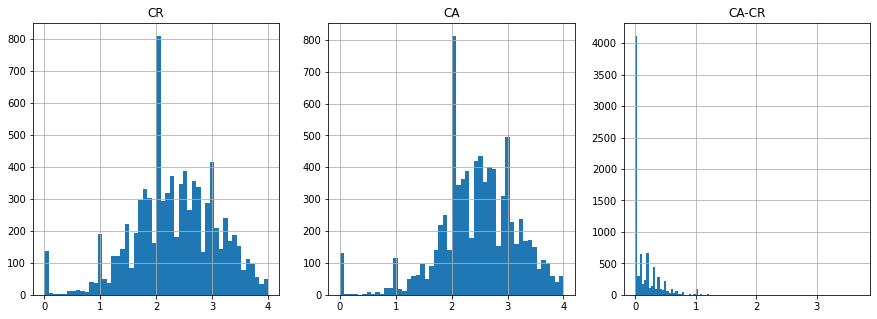

In [50]:
fig, axes = plt.subplots(1, 3,figsize=(15,5))
base_2018_encoded['CR'].hist(ax=axes[0],bins=50)
base_2018_encoded['CA'].hist(ax=axes[1],bins=50)
(base_2018_encoded['CA']-base_2018_encoded['CR']).hist(ax=axes[2],bins=100)
axes[0].set_title('CR')
axes[1].set_title('CA')
axes[2].set_title('CA-CR')

# Correlação entre CR e features

In [51]:
base_2018_encoded.head()

,ano_ingresso,frequentou_cursinho,escolaridade_pai,escolaridade_mae,forma_ingresso [Ampla concorrência],forma_ingresso [PEC-G/Transferência Ex Officio/Decisão Judicial],"forma_ingresso [Reserva de vagas (autodeclarado preto, pardo ou indígena)]",forma_ingresso [Reserva de vagas (cursado integralmente o ensino médio em escolas públicas)],forma_ingresso [Reserva de vagas (pessoa com deficiência)],forma_ingresso [Reserva de vagas (refugiado ou solicitante de refúgio - incluindo situação de vulnerabilidade econômica)],"forma_ingresso [Reserva de vagas (renda familiar bruta per capita igual ou inferior a 1,5 salário mínimo)]",forma_ingresso [Transferência externa],forma_ingresso [Prefiro não responder],idade,sexo_biologico,nmr_filhos,meio_transporte [Caminhando (percurso total)],meio_transporte [Caminhando (parte do percurso)],meio_transporte [Bicicleta],meio_transporte [Carona],meio_transporte [Fretado/van],meio_transporte [Metrô],meio_transporte [Ônibus da UFABC],meio_transporte [Transporte particular (carro)],meio_transporte [Transporte particular (moto)],meio_transporte [Uber/taxi],meio_transporte [Trem],meio_transporte [Trólebus/ônibus - exceto ônibus da UFABC],meio_transporte [Prefiro não responder],tempo_medio_chegada_na_ufabc,atividade_extraclasse [Não participo de atividades extraclasse relacionadas à UFABC],atividade_extraclasse [AIESEC],atividade_extraclasse [Atividades culturais],atividade_extraclasse [Atividades de extensão],atividade_extraclasse [Atividades esportivas],atividade_extraclasse [AXIS  Atlética UFABC/CAAP],atividade_extraclasse [Coletivos de cunho religioso],atividade_extraclasse [Coletivos relacionados ao ativismo político],atividade_extraclasse [Coletivos relacionados ao empreendedorismo],atividade_extraclasse [Cursos de idiomas],atividade_extraclasse [DCE/Diretório Acadêmico/Centros Acadêmicos.],atividade_extraclasse [Empresas júniores],atividade_extraclasse [ENACTUS UFABC],atividade_extraclasse [Coletivos LGBTQ+],atividade_extraclasse [Coletivos feministas],atividade_extraclasse [Coletivos étnico-raciais],atividade_extraclasse [GPDA UFABC],atividade_extraclasse [Infanteria UFABC],atividade_extraclasse [Ramo Estudantil IEEE da UFABC],"atividade_extraclasse [Representação discente (ConsUni, ConsEPE, Comissões, etc)]",atividade_extraclasse [UFABC Cheer],atividade_extraclasse [Outras atividades extraclasse (não listadas acima)],atividade_extraclasse [Prefiro não responder],nivel_conhecimento_idioma [Alemão],nivel_conhecimento_idioma [Espanhol],nivel_conhecimento_idioma [Francês],nivel_conhecimento_idioma [Inglês],nivel_conhecimento_idioma [Italiano],nivel_conhecimento_idioma [Japonês],nivel_conhecimento_idioma [Libras],dificuldades [Nenhuma],dificuldades [Acessibilidade nas dependências da UFABC],dificuldades [Assuntos familiares/pessoais],dificuldades [Déficit de formação acadêmica básica],dificuldades [Didática dos docentes],dificuldades [Discriminações e preconceitos],dificuldades [Falta de disciplina/hábito de estudo],dificuldades [Problemas de saúde/psicológicos],dificuldades [Questões financeiras],dificuldades [Questões profissionais],dificuldades [Prefiro não responder],dificuldades_emocionais [Nenhuma],dificuldades_emocionais [Ansiedade],"dificuldades_emocionais [Desânimo, falta de vontade de fazer as coisas]",dificuldades_emocionais [Distúrbios alimentares],"dificuldades_emocionais [Ideia de morte (Pensamentos homicidas, medo da morte, etc)]",dificuldades_emocionais [Medo/pânico],dificuldades_emocionais [Pensamento suicida],dificuldades_emocionais [Sensação de desamparo/desespero/desesperança],dificuldades_emocionais [Sensação de desatenção/desorientação/confusão mental],dificuldades_emocionais [Sentimento de solidão],dificuldades_emocionais [Timidez excessiva],dificuldades_emocionais [Tristeza persistente],dificuldades_emocionais [Prefiro não responder],preconceito_discriminacao [Não],"preconceito_discriminacao [Sim, pela instituição de ensino em que cursei o ensino médio]","preconceito_discrimi

In [52]:
multiple_choice = []
for c in base_2018_encoded.columns:
    if "[" in c:
        aux = c.split('[')[0].replace(' ','')
        if aux not in multiple_choice:
            multiple_choice.append(aux)

In [53]:
for c in base_2018_encoded.columns:
    if "nota" in c:
        print(c)

nota_infraestrutura_sa [Acessibilidade interna do campus]
nota_infraestrutura_sa [Ambulatório]
nota_infraestrutura_sa [Banheiros e vestiários]
nota_infraestrutura_sa [Espaços de convivência]
nota_infraestrutura_sa [Espaços de estudo]
nota_infraestrutura_sa [Estacionamento]
nota_infraestrutura_sa [Laboratórios de informática]
nota_infraestrutura_sa [Laboratórios secos]
nota_infraestrutura_sa [Laboratórios úmidos]
nota_infraestrutura_sa [Localização do campus]
nota_infraestrutura_sa [Restaurante Universitário]
nota_infraestrutura_sa [Salas de aula]
nota_infraestrutura_sa [Segurança nas dependências do campus]
nota_infraestrutura_sa [Segurança no entorno do campus]
nota_infraestrutura_sa [Sinalização no campus]
nota_infraestrutura_sbc [Acessibilidade interna do campus]
nota_infraestrutura_sbc [Ambulatório]
nota_infraestrutura_sbc [Banheiros e vestiários]
nota_infraestrutura_sbc [Espaços de convivência]
nota_infraestrutura_sbc [Espaços de estudo]
nota_infraestrutura_sbc [Estacionamento]
no

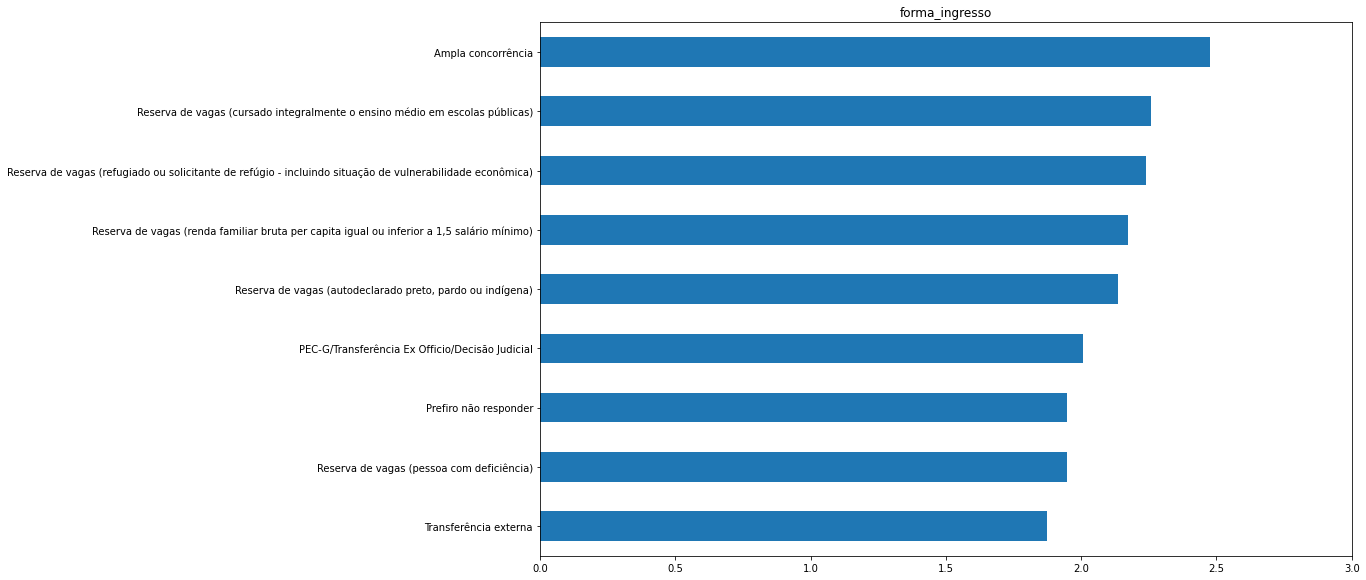

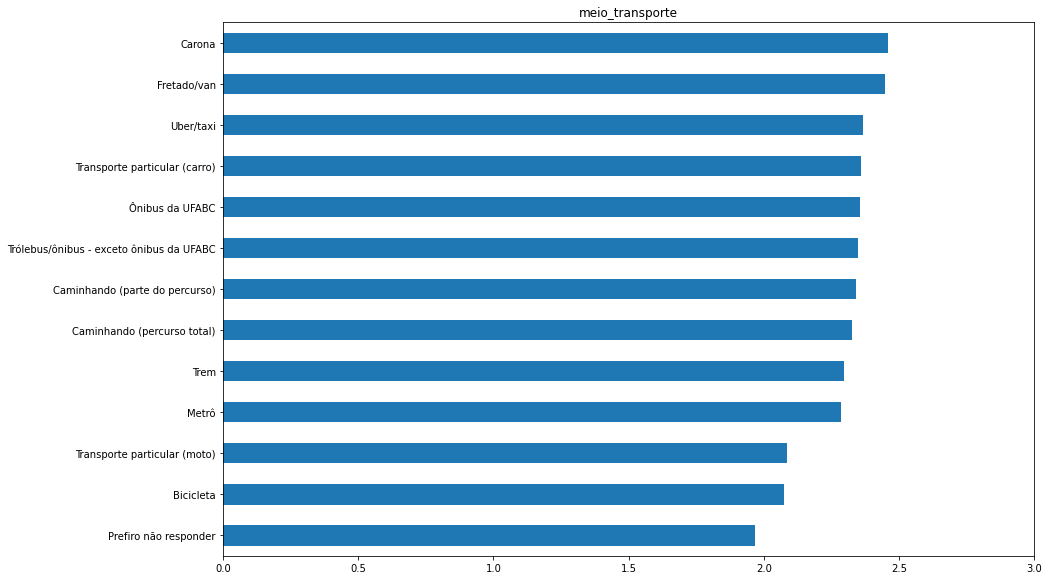

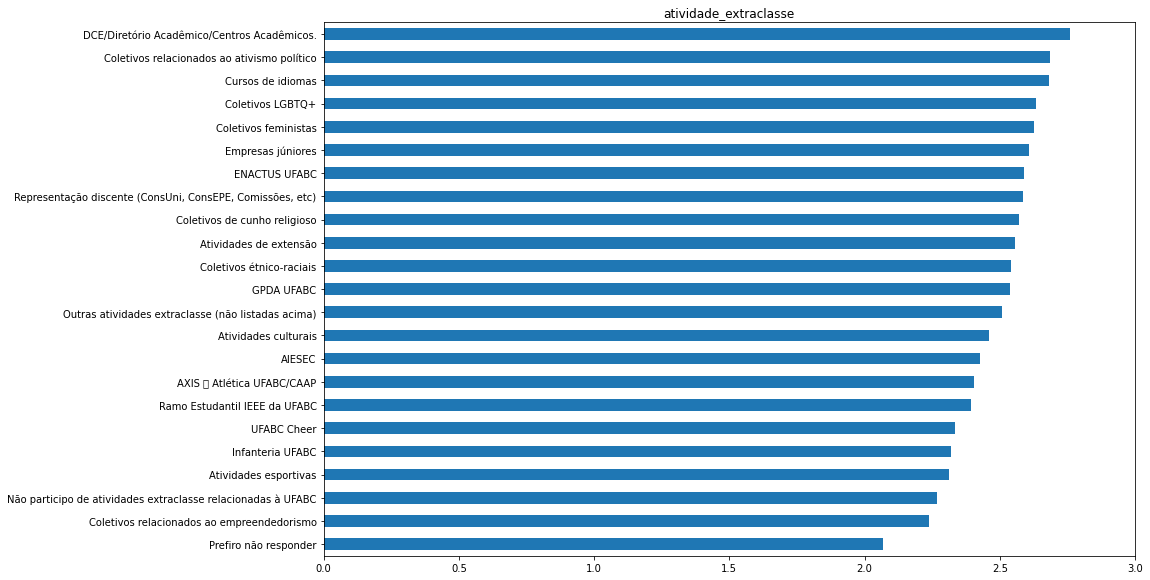

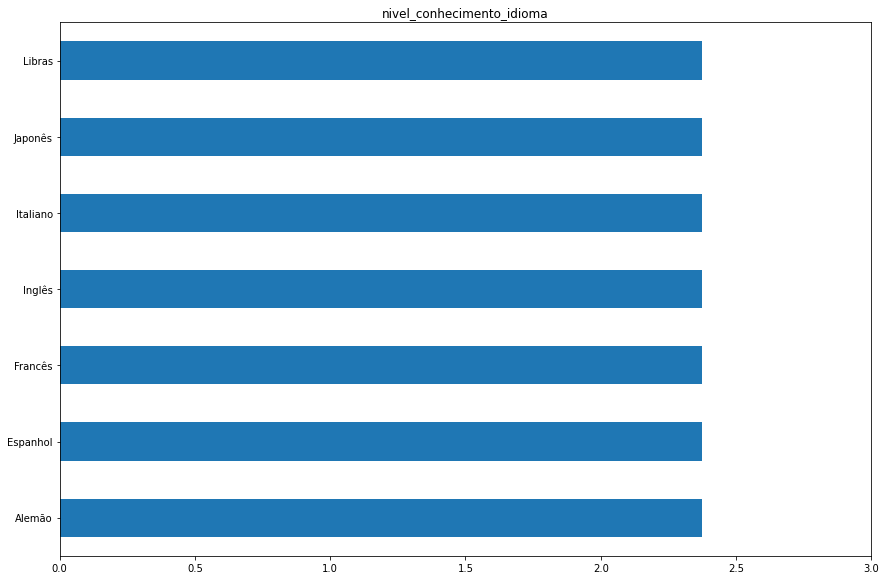

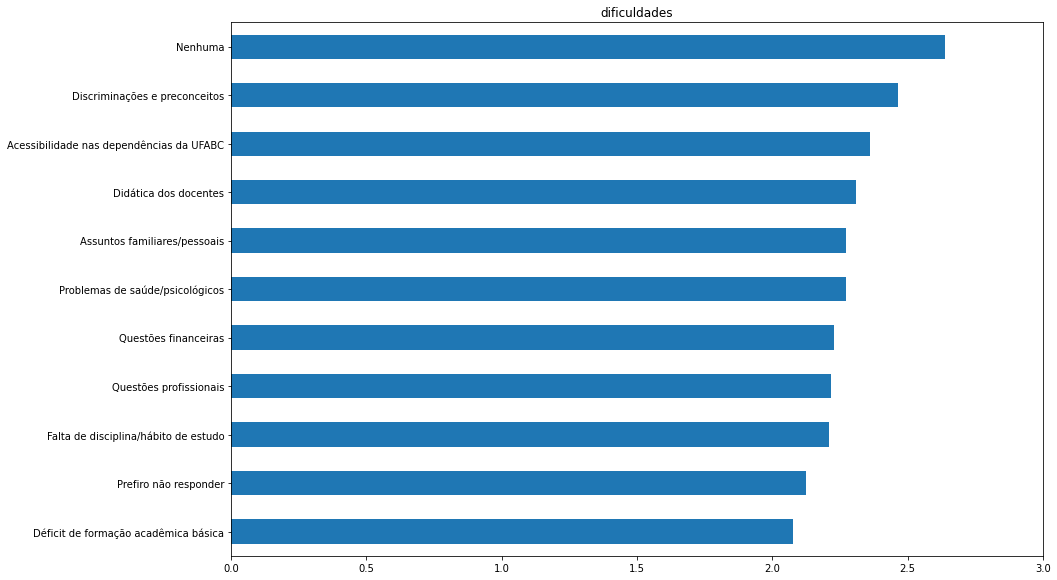

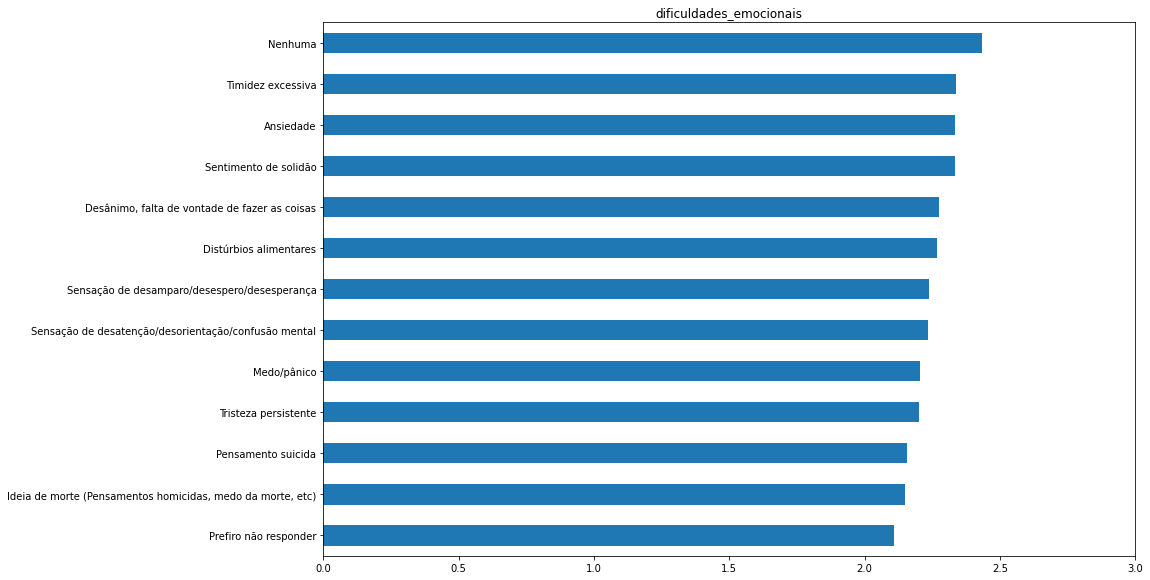

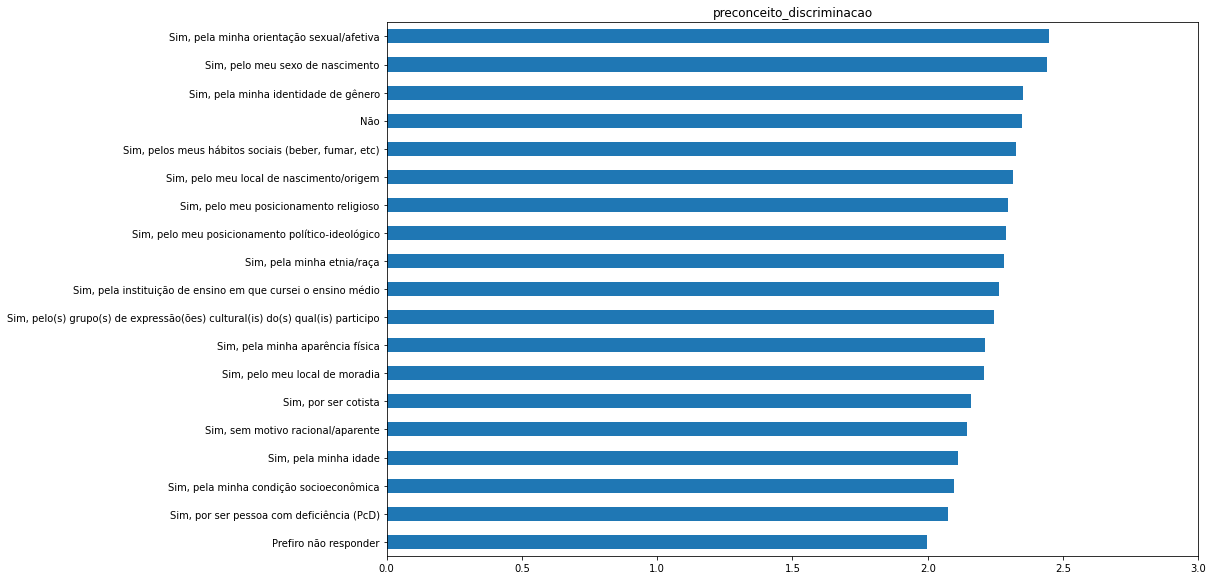

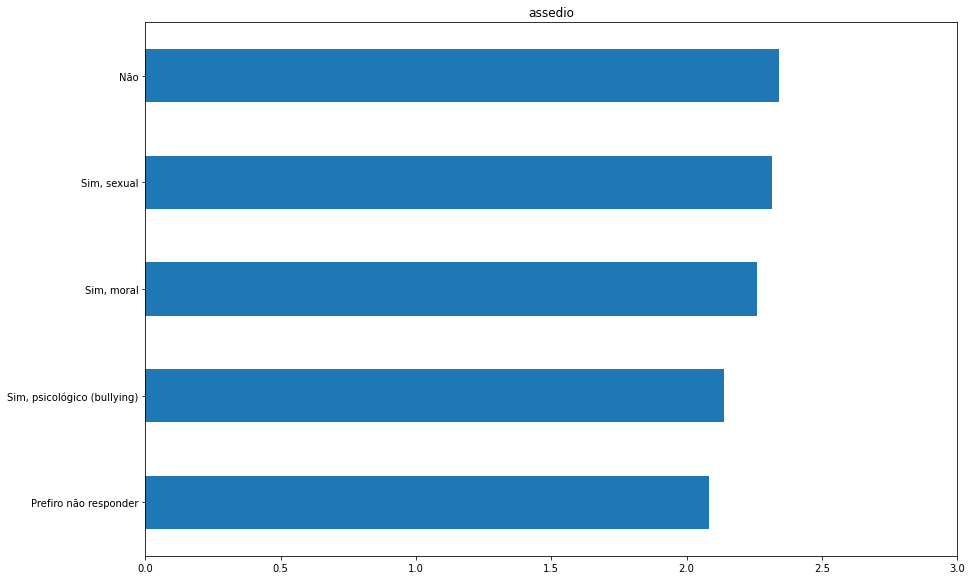

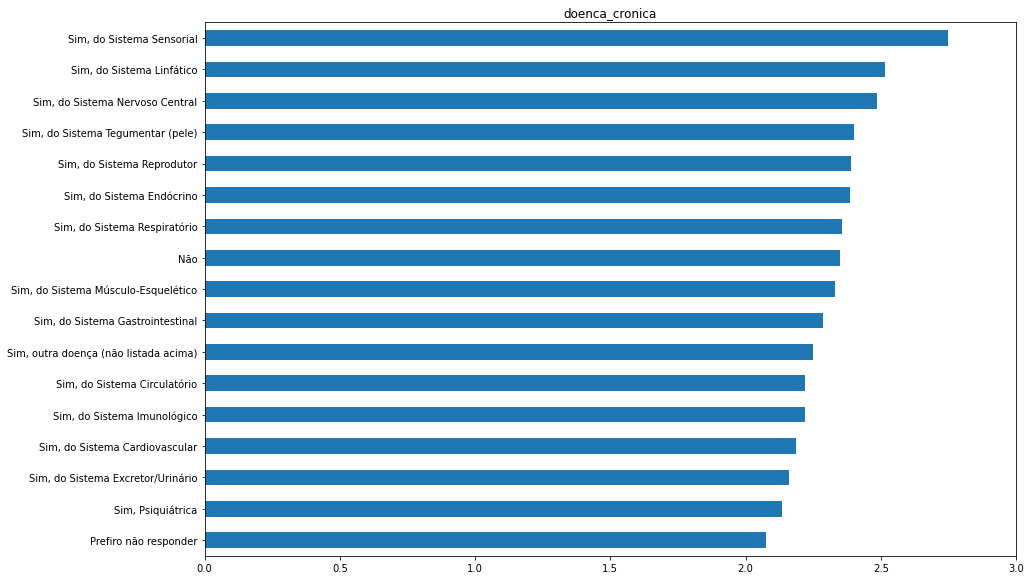

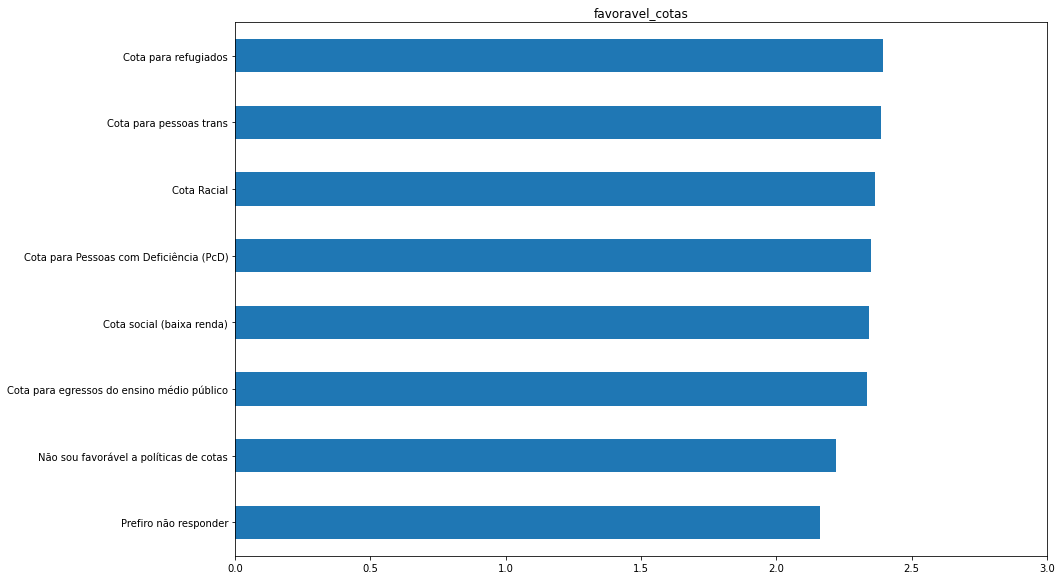

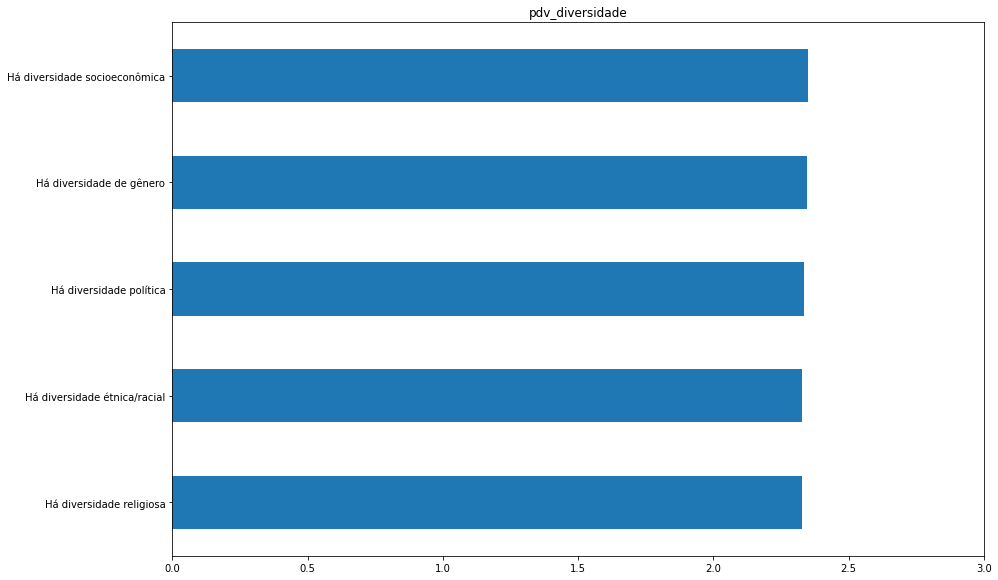

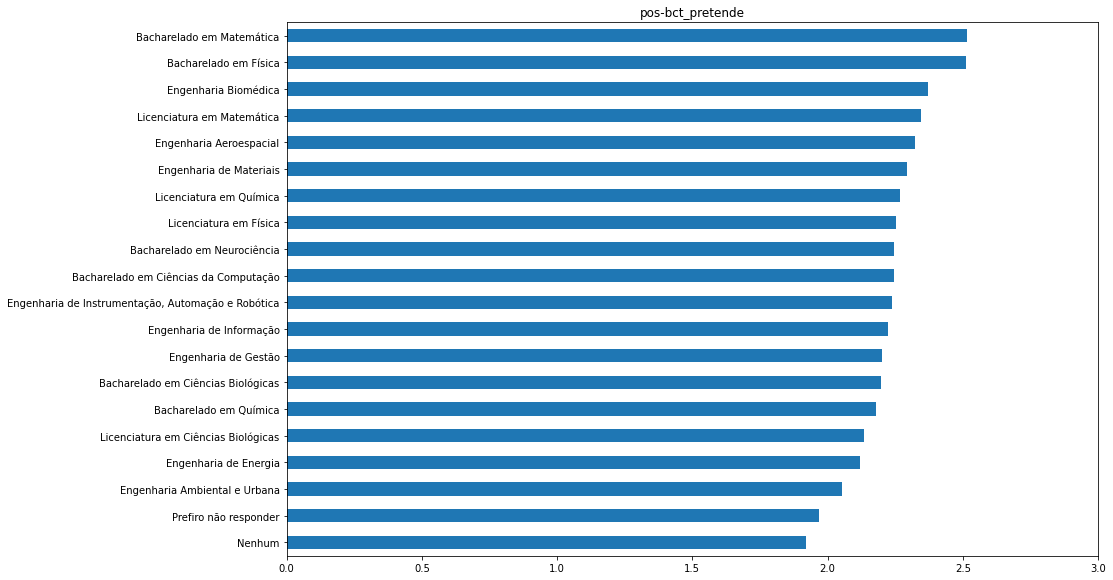

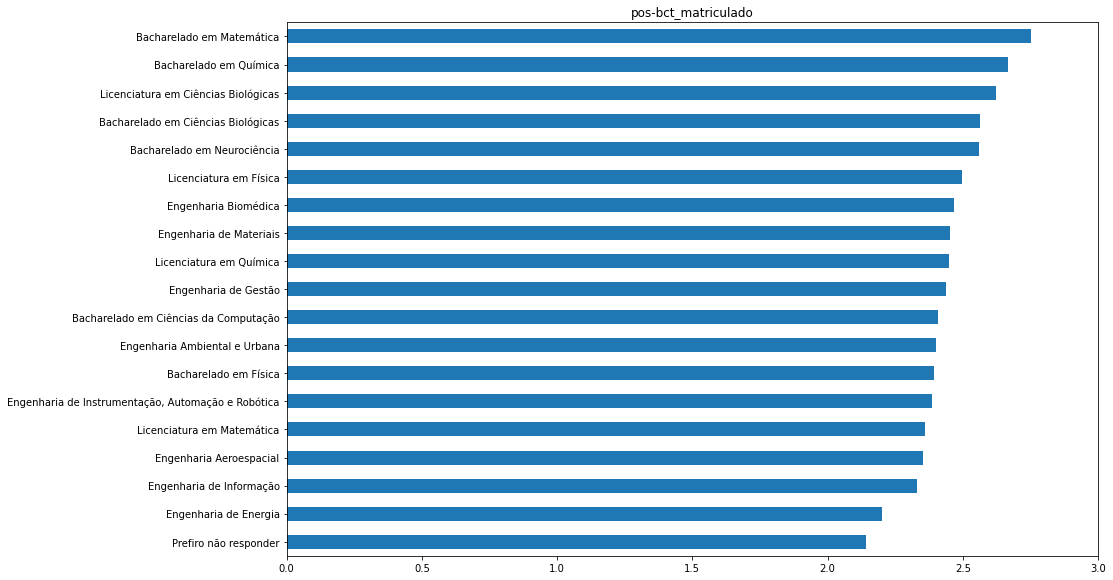

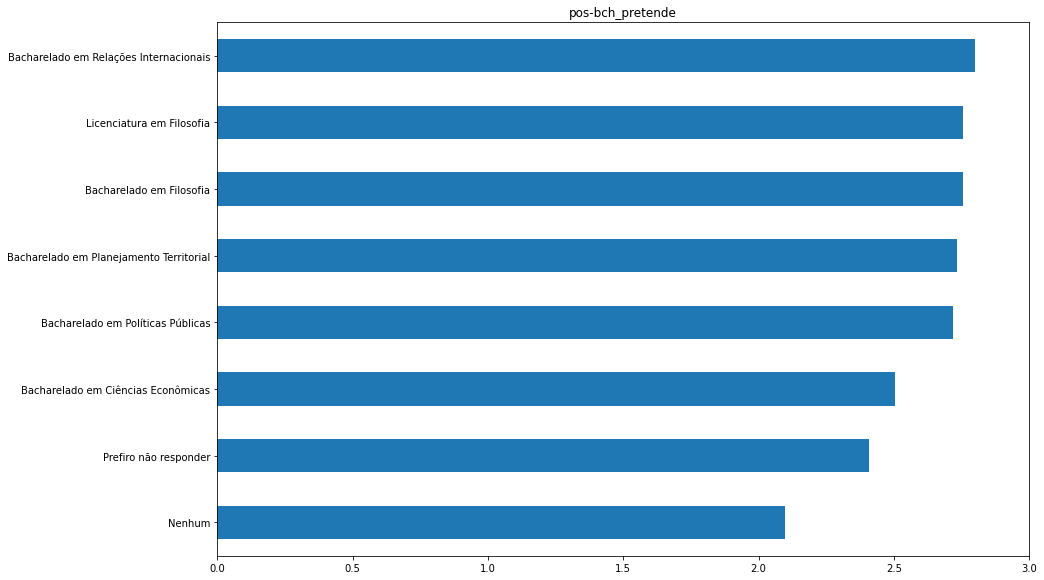

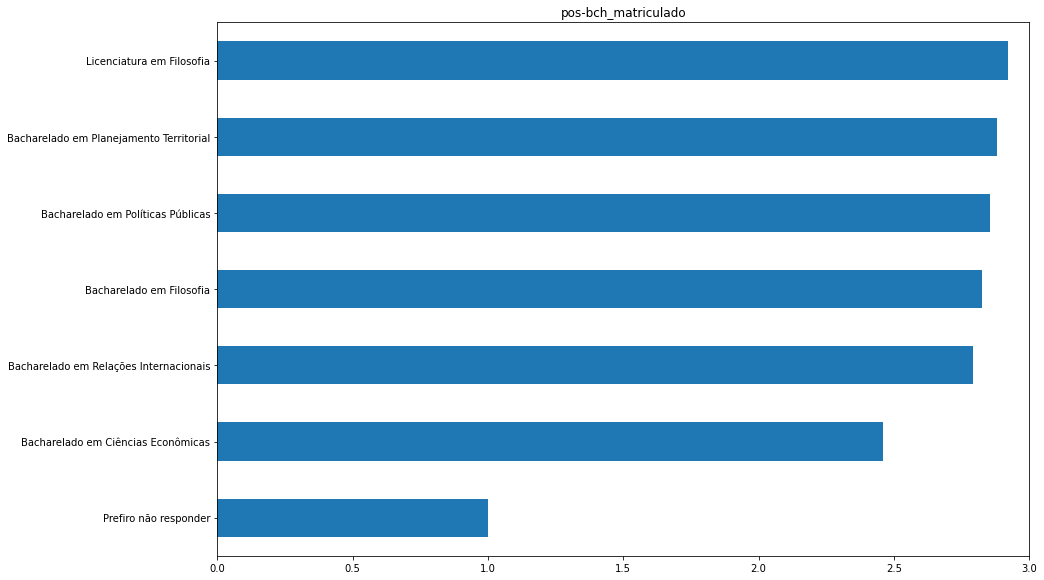

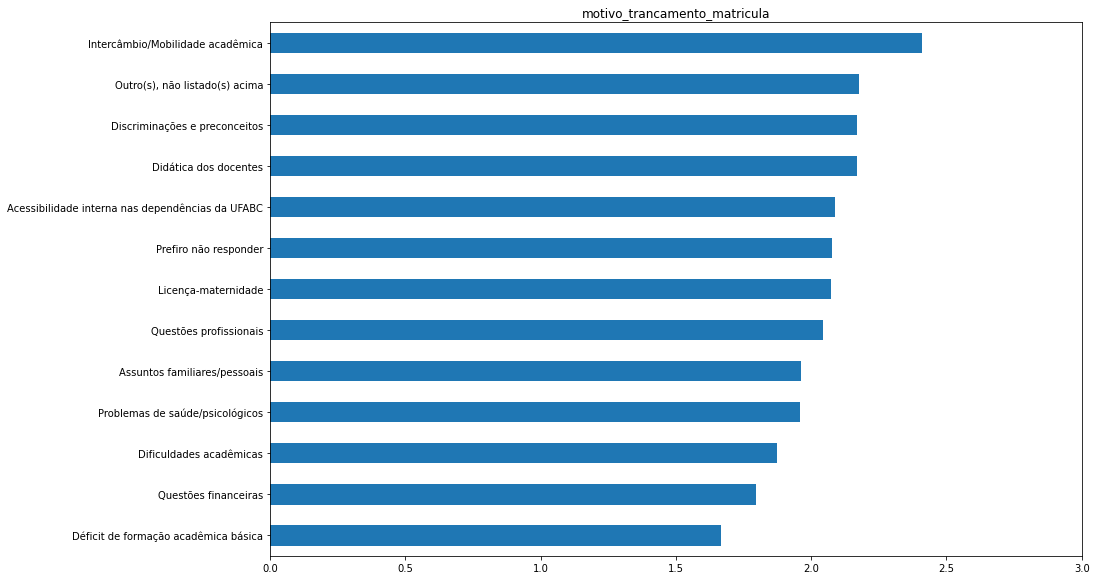

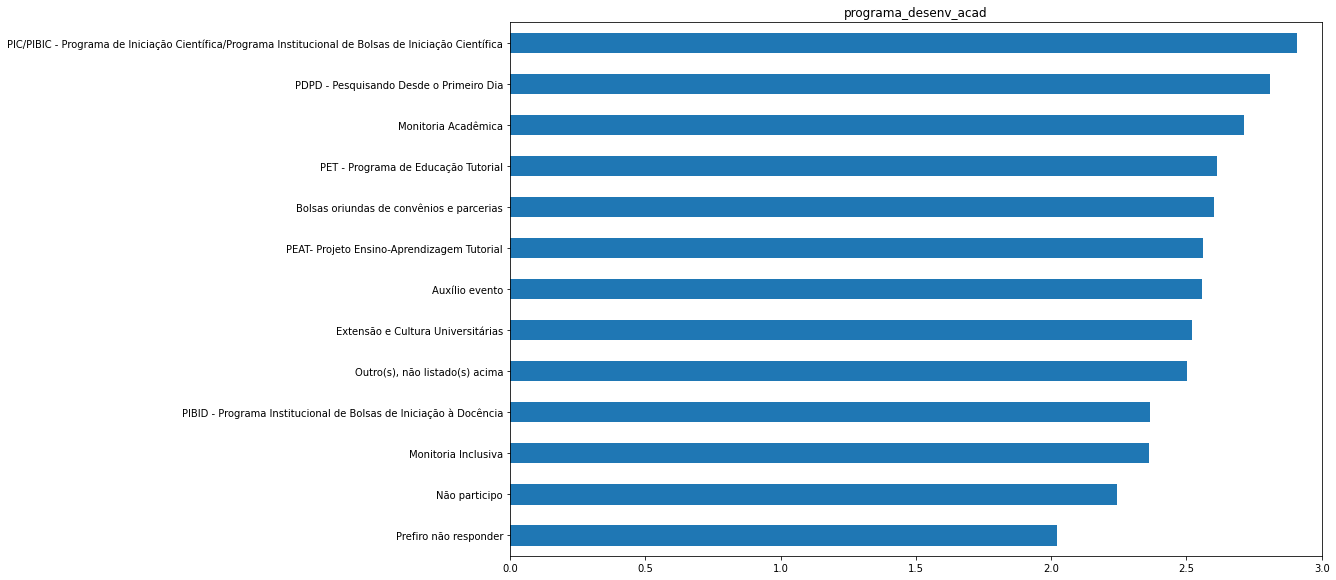

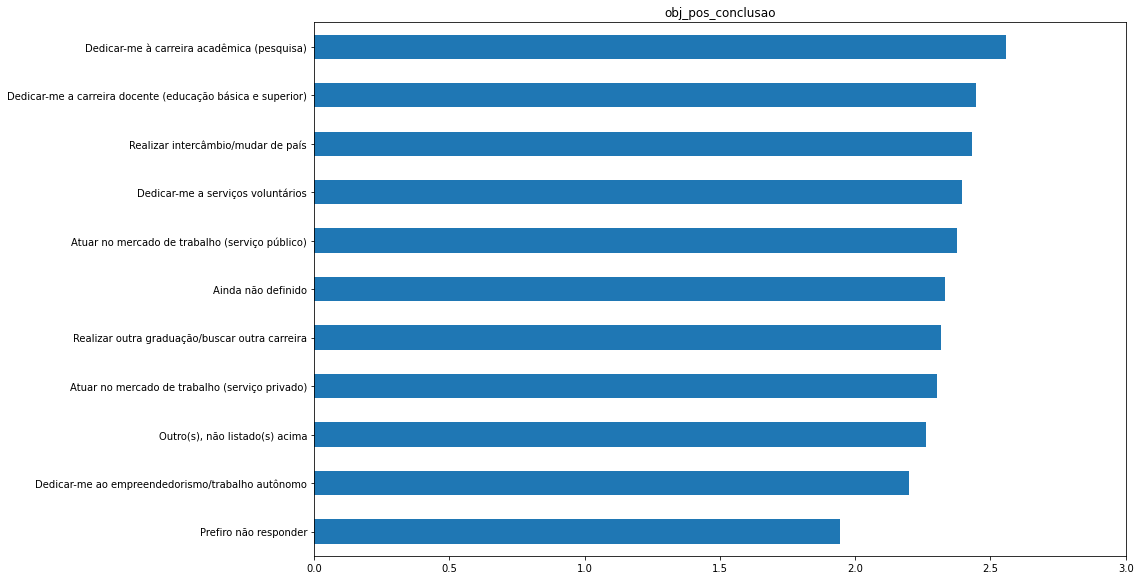

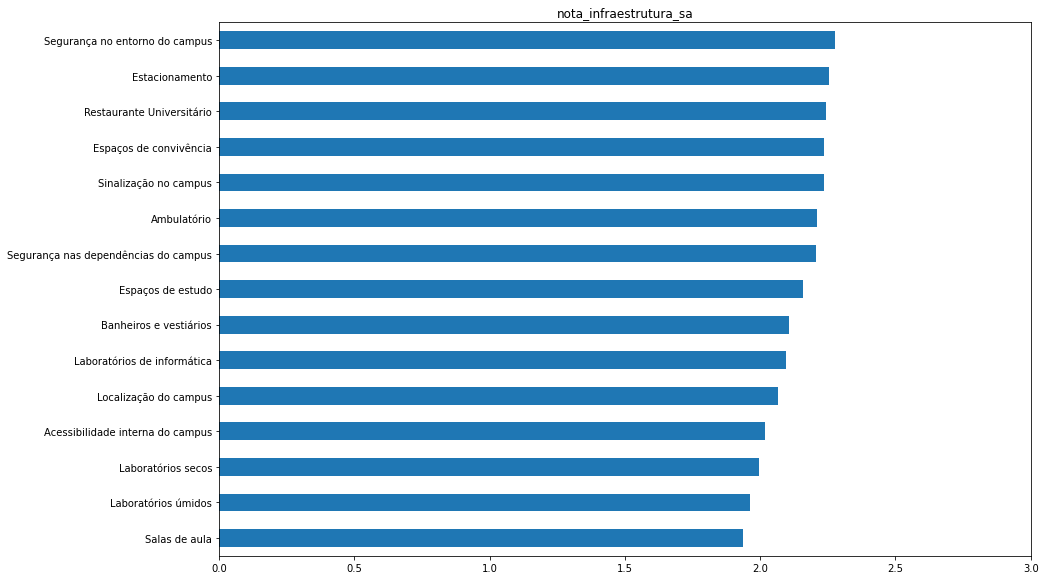

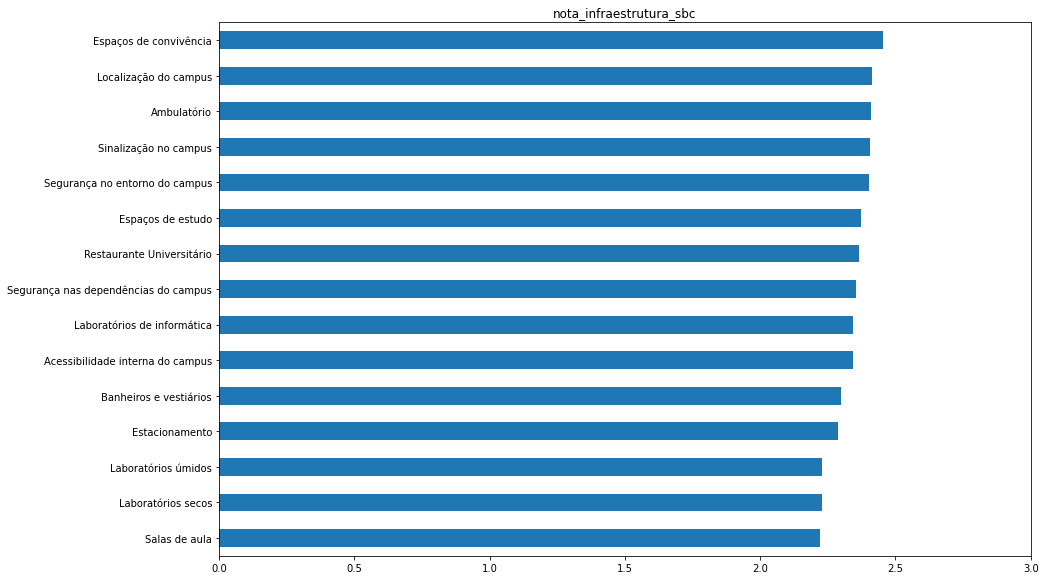

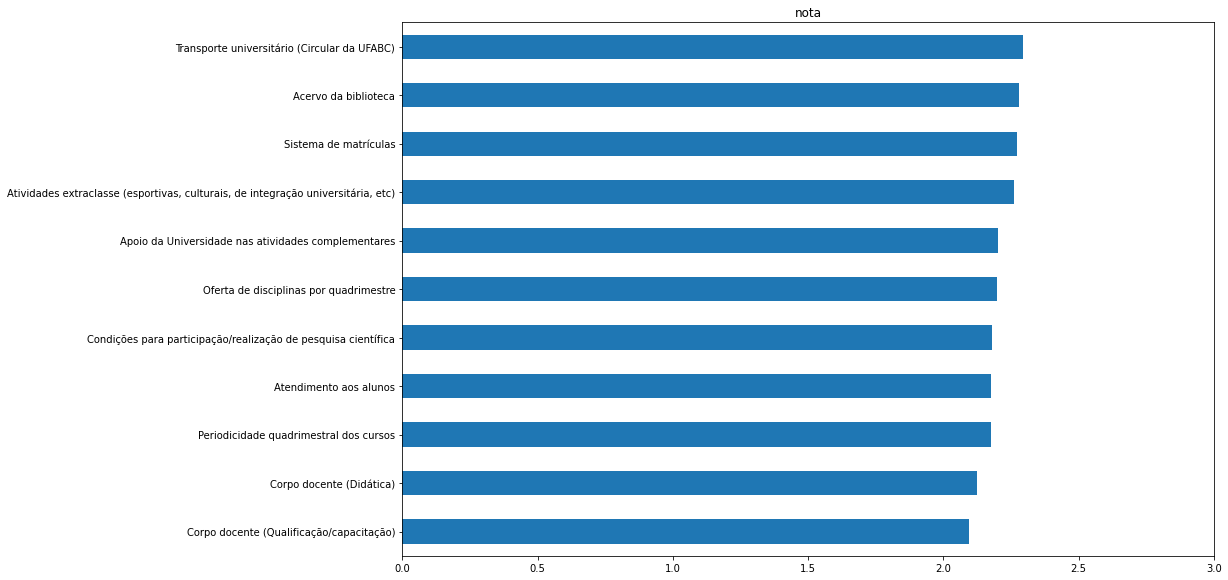

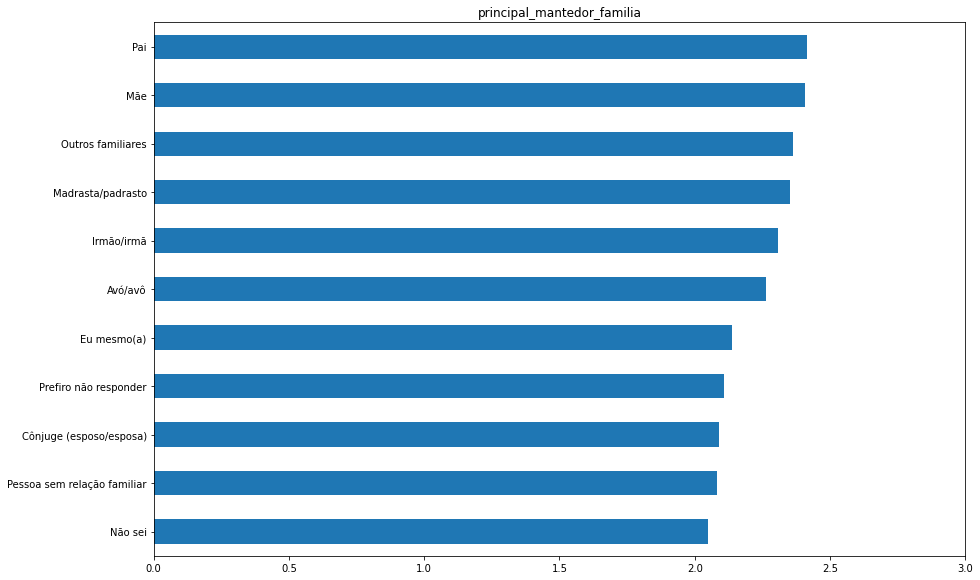

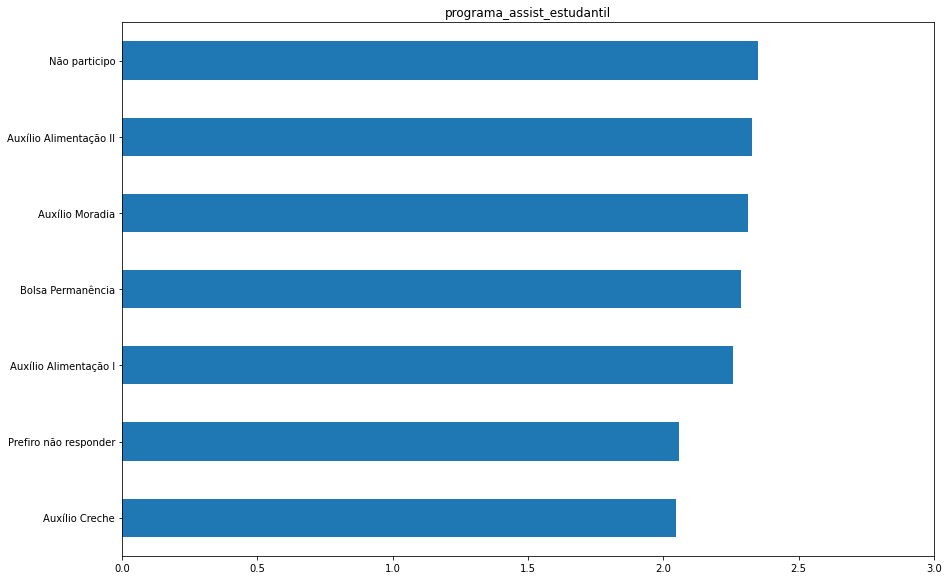

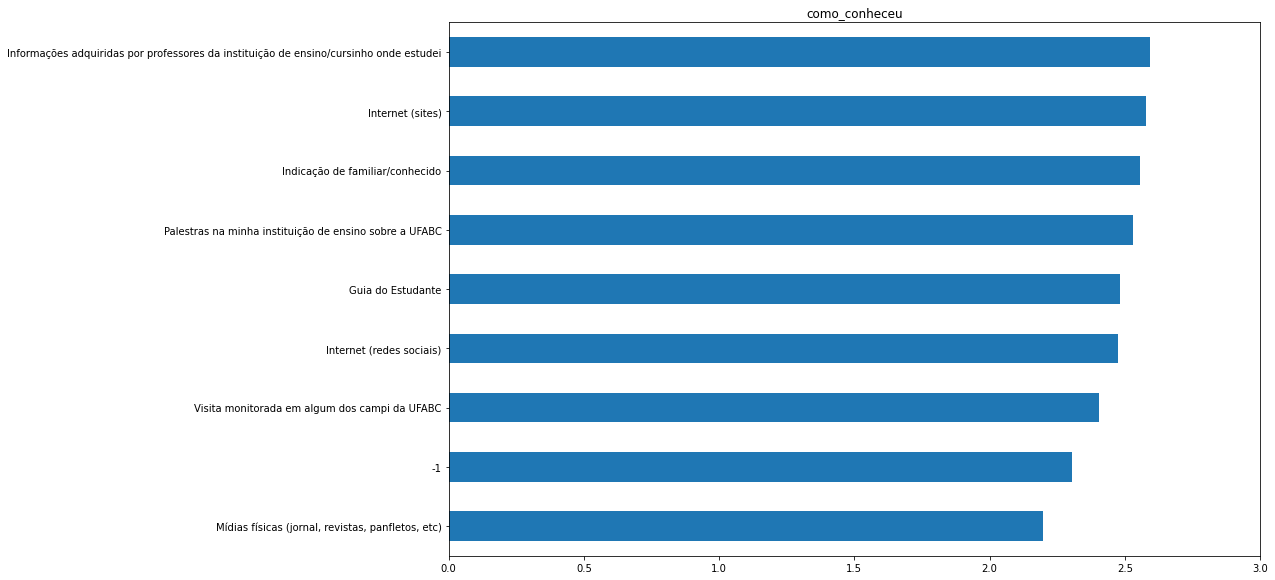

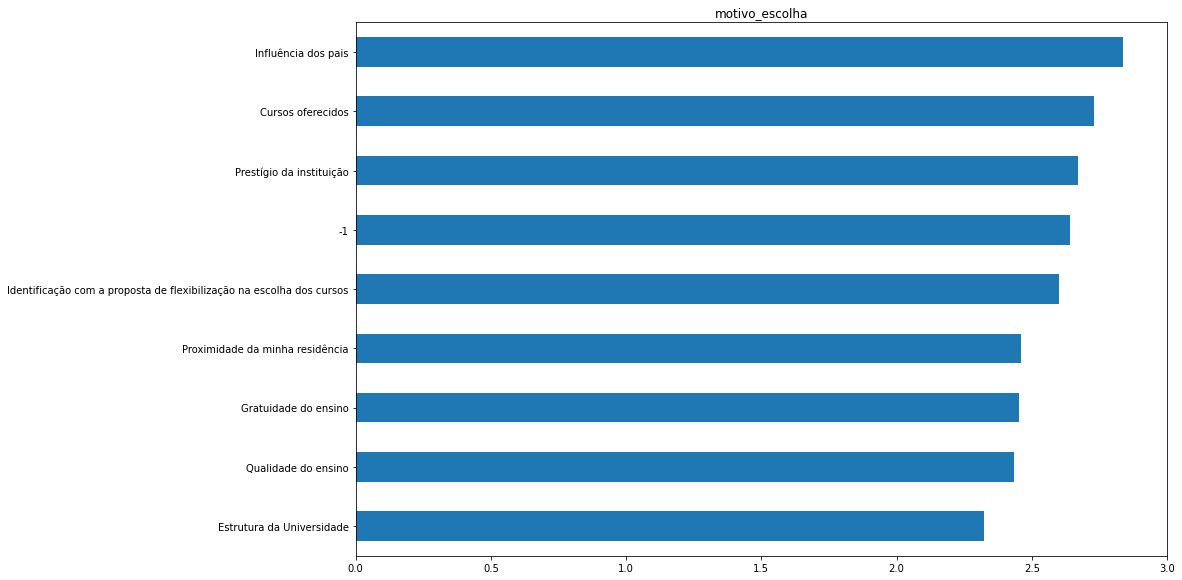

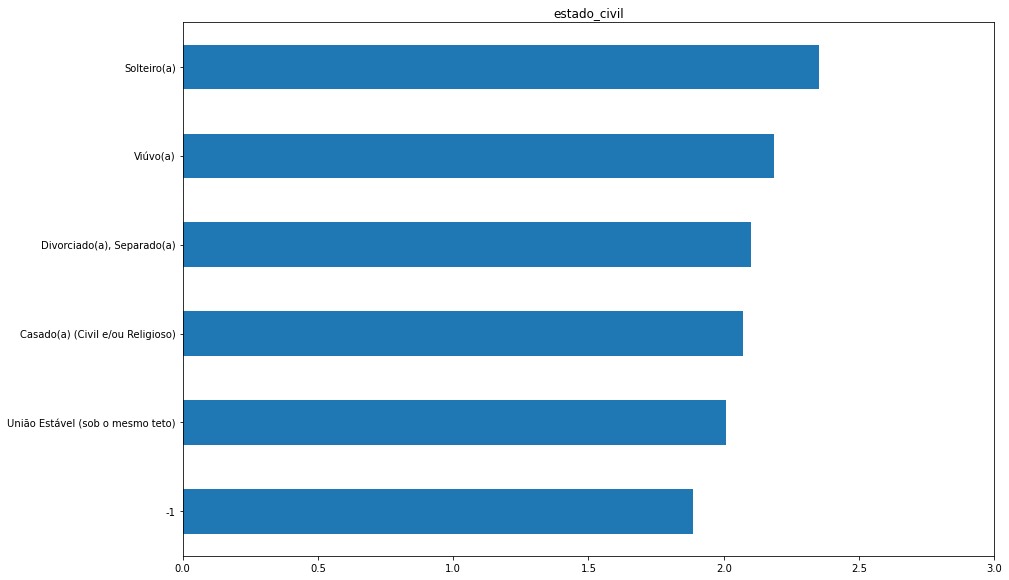

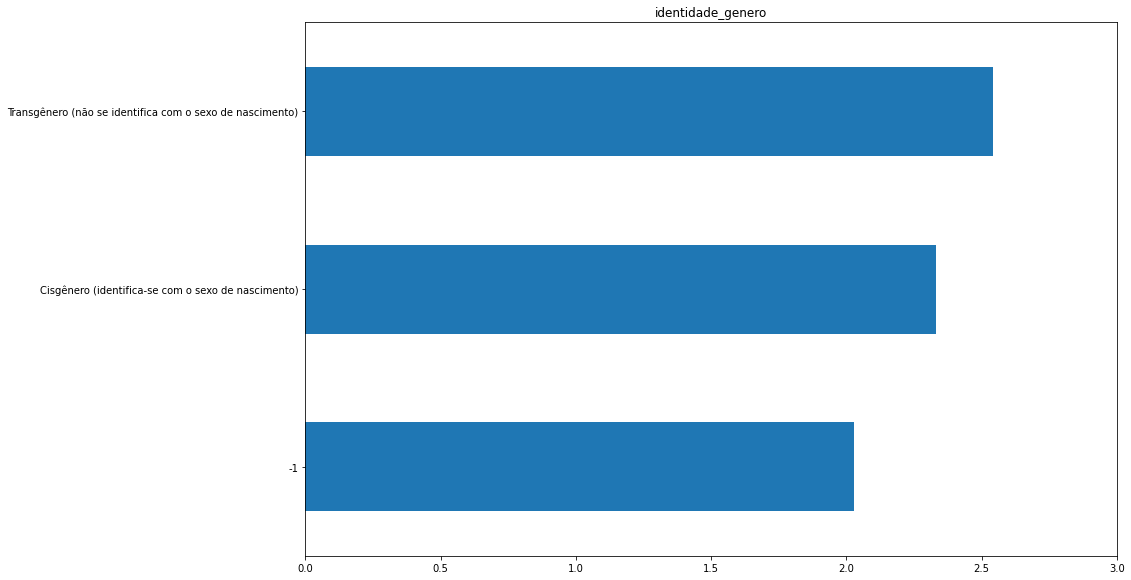

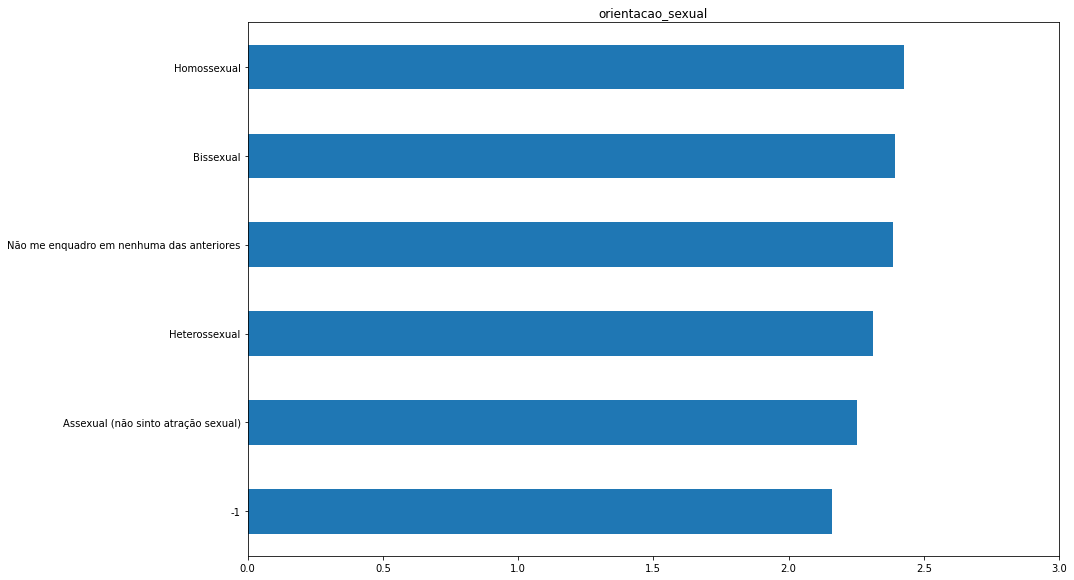

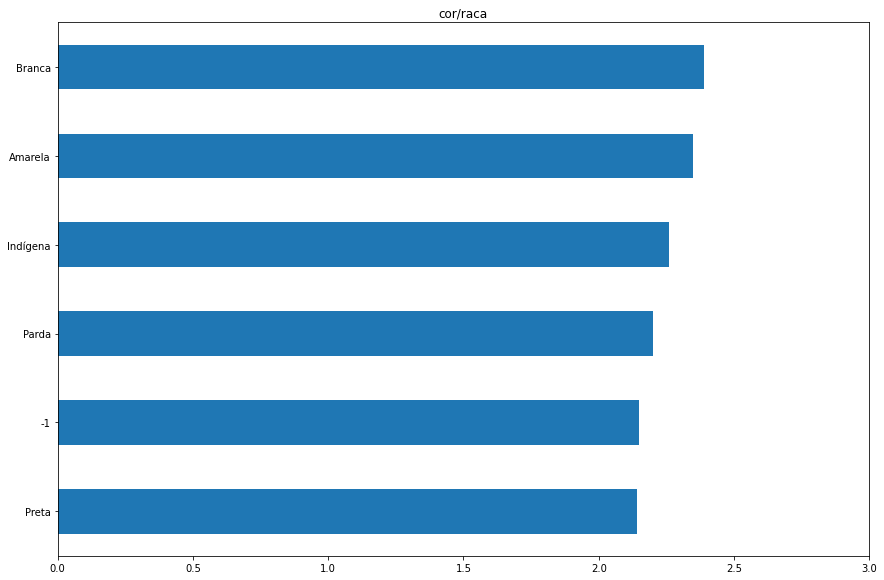

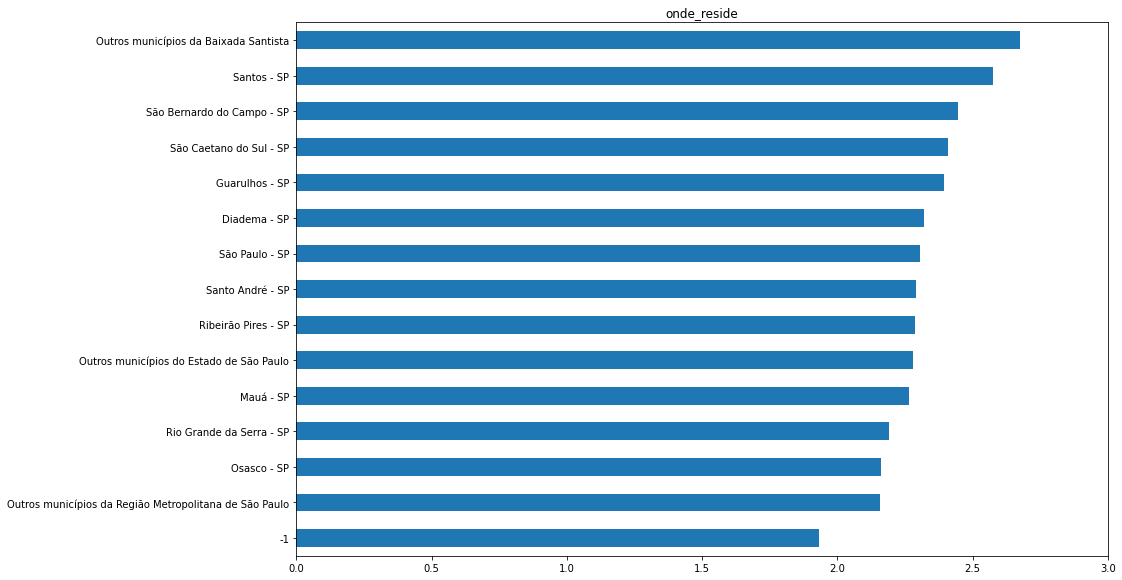

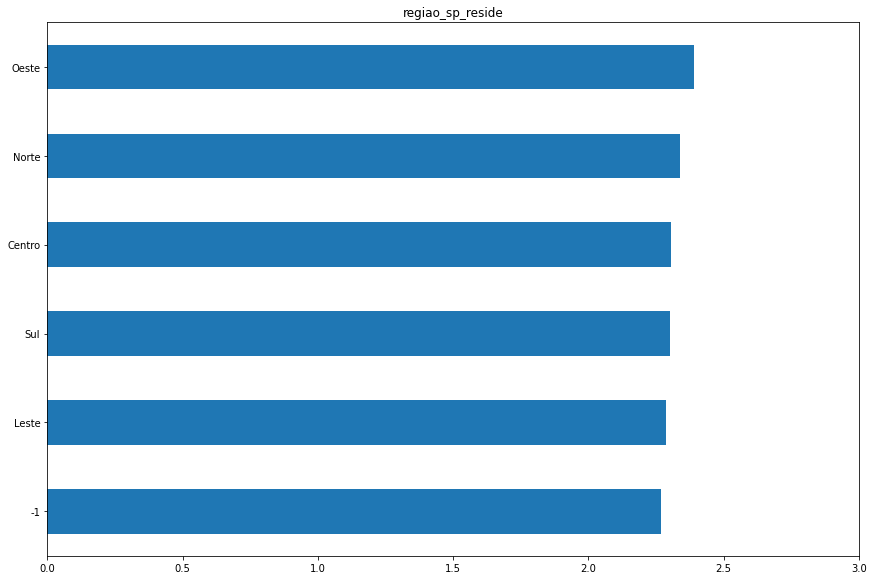

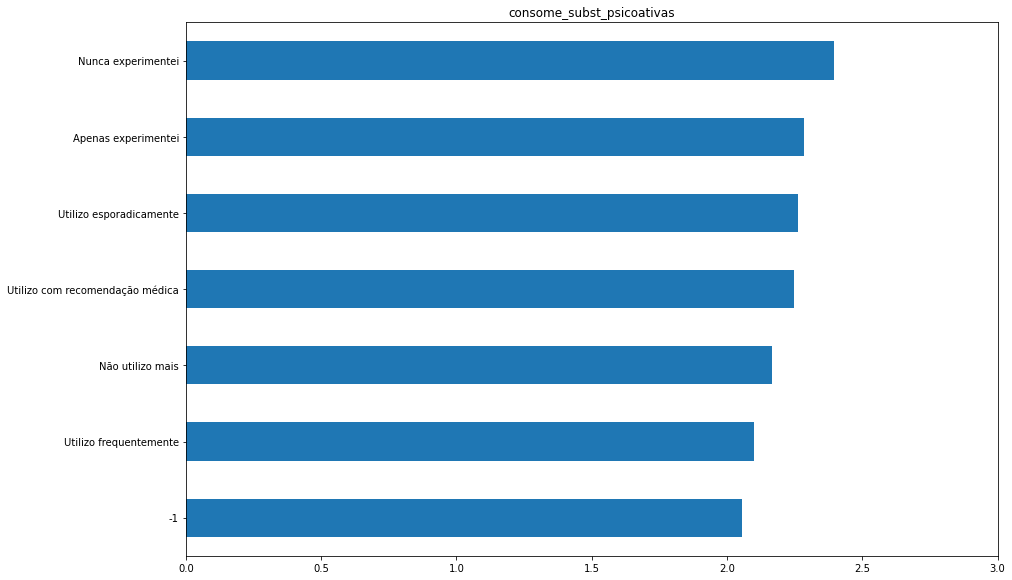

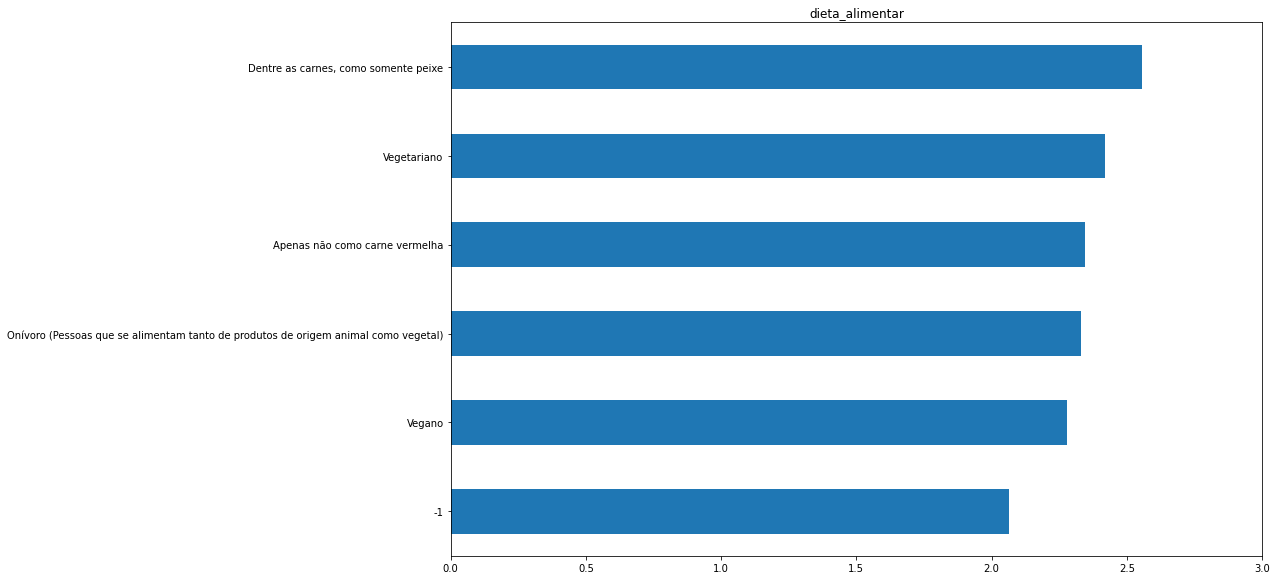

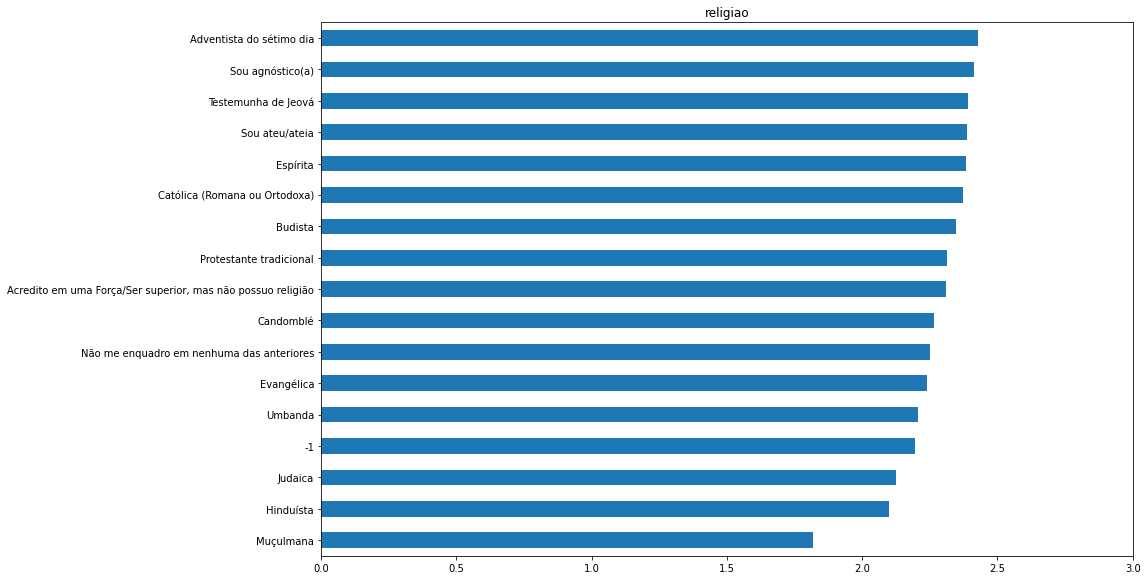

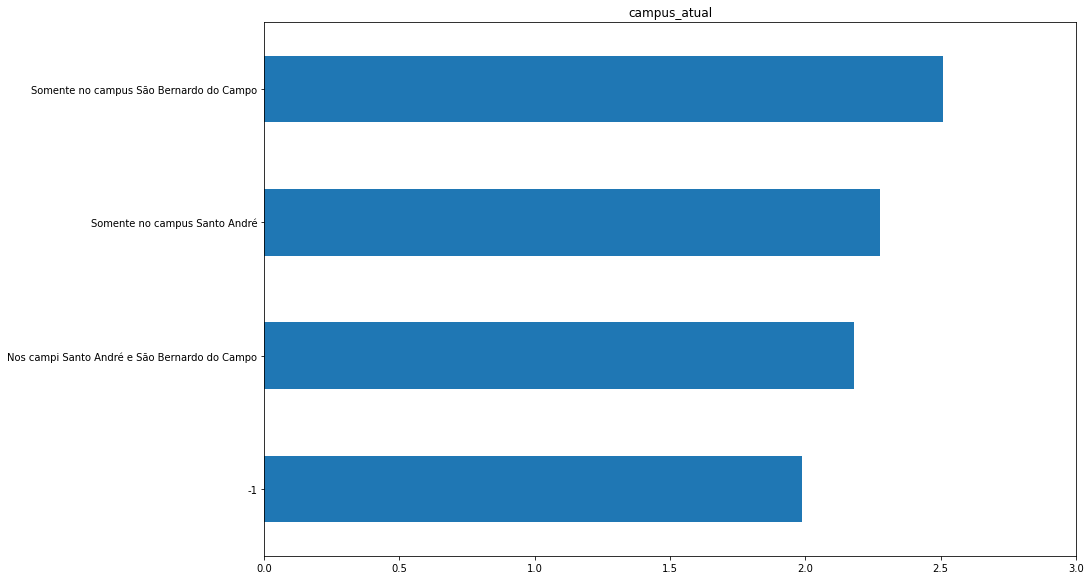

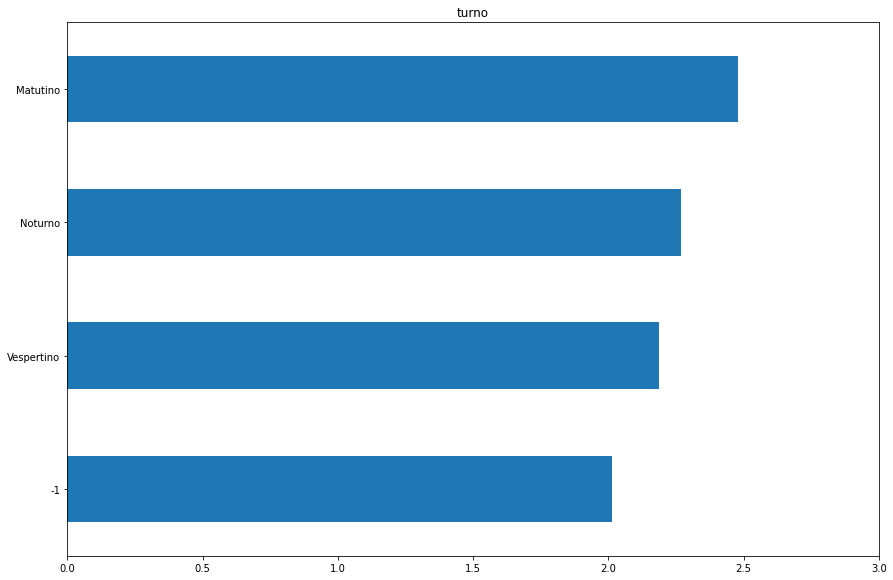

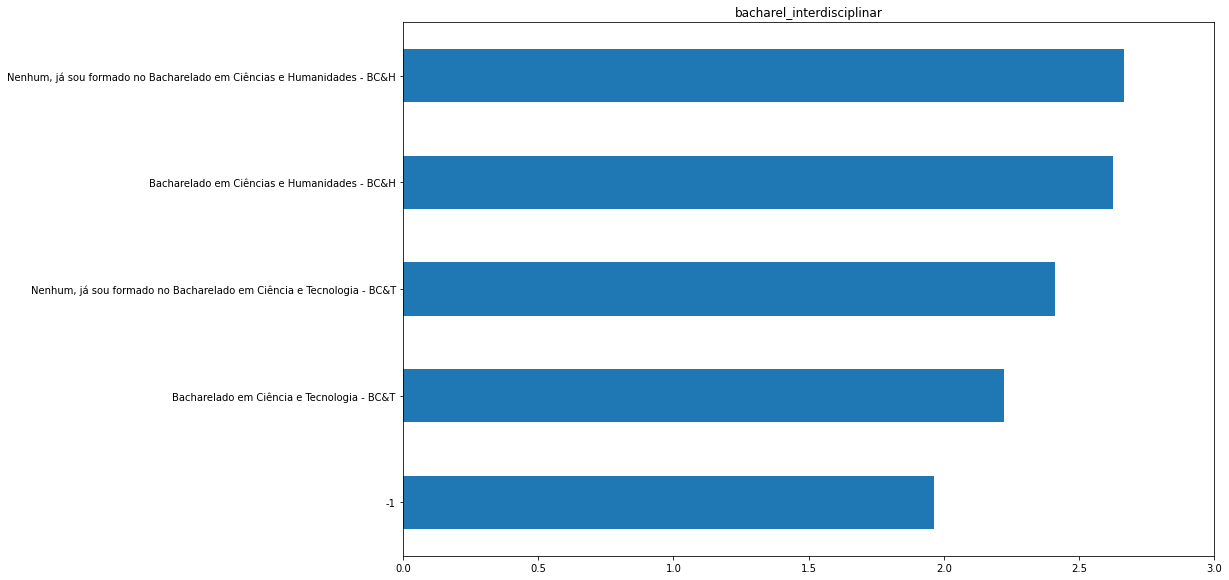

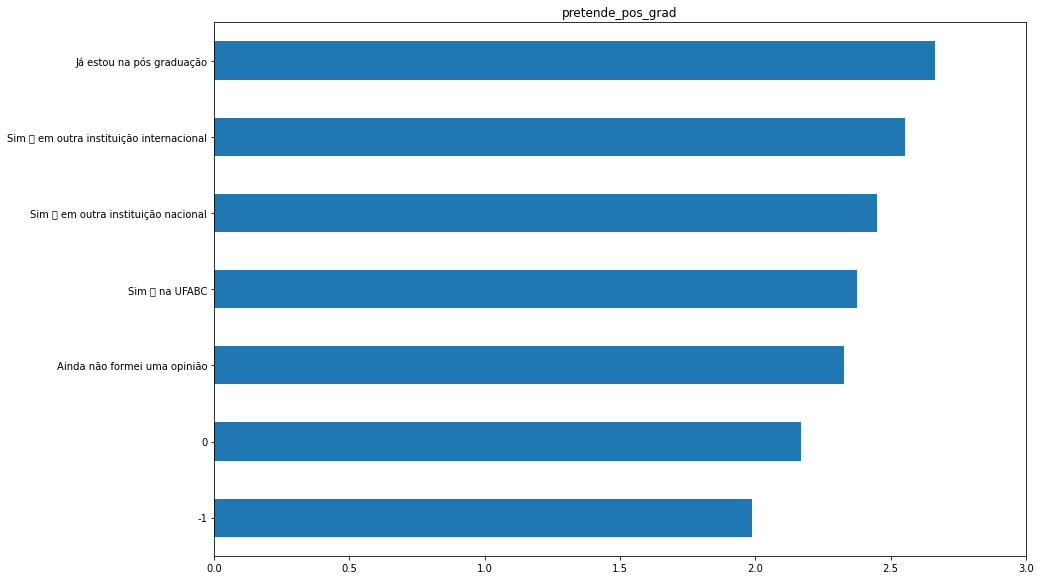

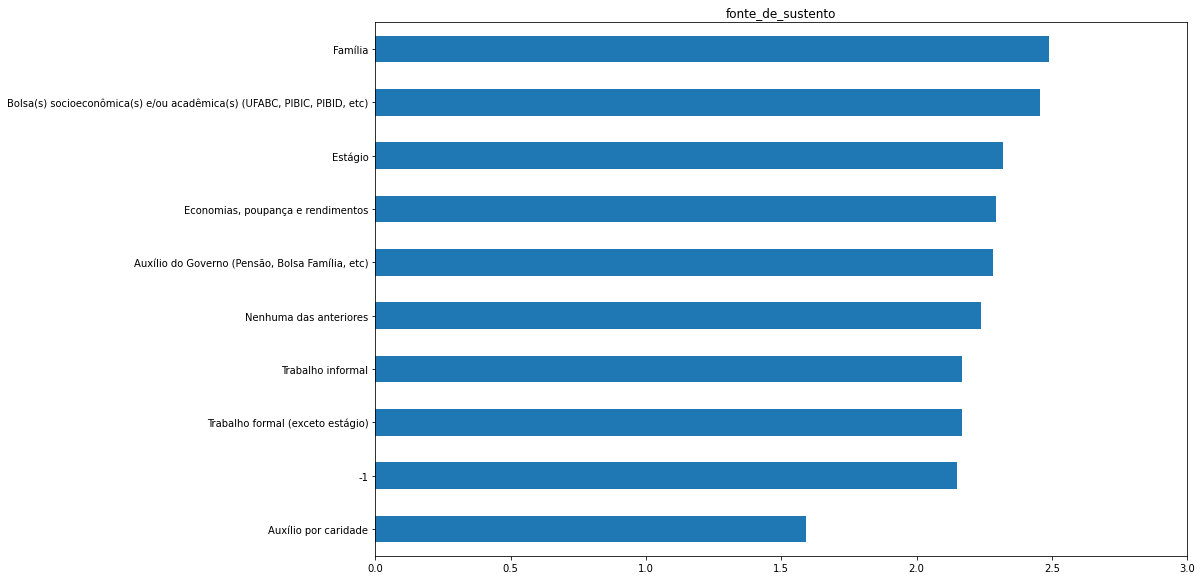

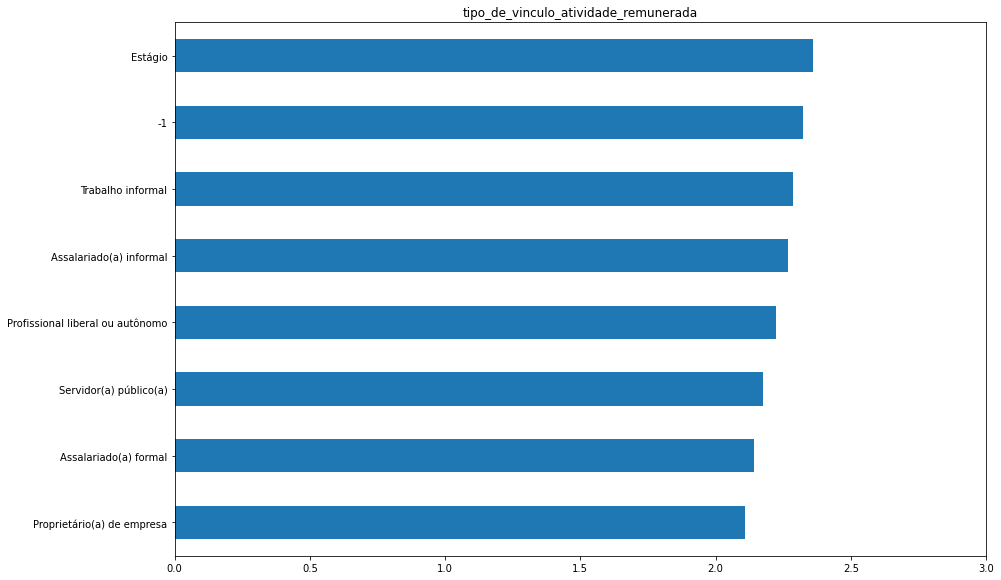

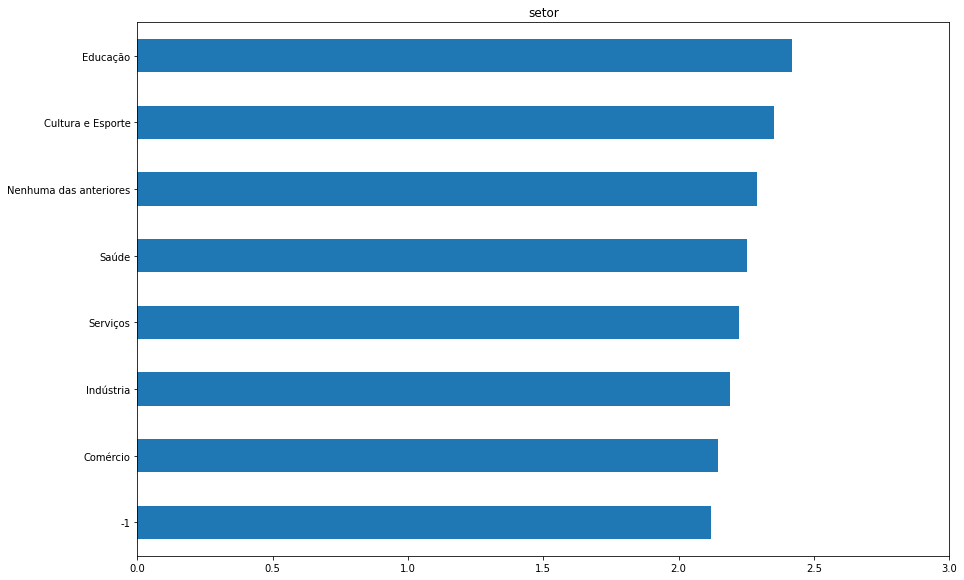

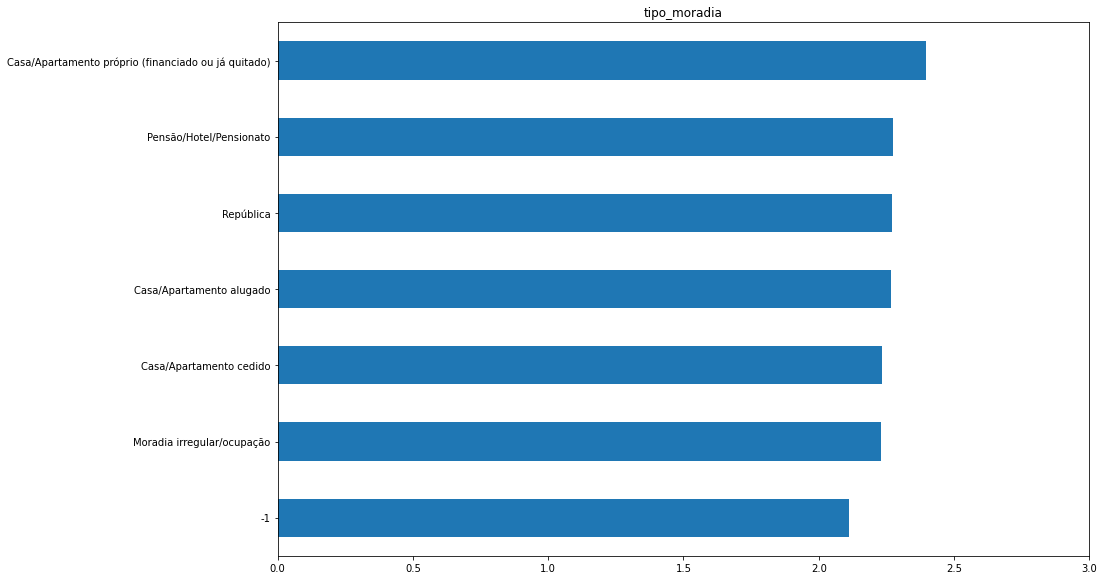

In [54]:
for q in multiple_choice:
    temp = base_2018_encoded.filter(regex='('+q+r'[ ]*\[)|(CR)').copy()
    help_series = temp['CR']
    temp.drop('CR',axis=1,inplace=True)
    
    temp.columns = [x.split('[')[1].replace(']','') for x in list(temp.columns)]
    temp['CR']=help_series
    temp = pd.melt(temp,id_vars=['CR'])
    temp = temp.loc[temp['value']==1]
    temp = temp.groupby('variable')['CR'].mean().sort_values()
    
    fig,axs = plt.subplots(figsize=(12,8))
    plt.tight_layout()
    axs.set_title(q)
    temp.plot(kind='barh',ax=axs,xlabel='')
    axs.set_xlim(0,3)
    plt.show()

In [55]:
numeric_choice = []
for c in base_2018_encoded.columns:
    if "[" not in c:
        aux = c
        if aux not in multiple_choice:
            numeric_choice.append(aux)

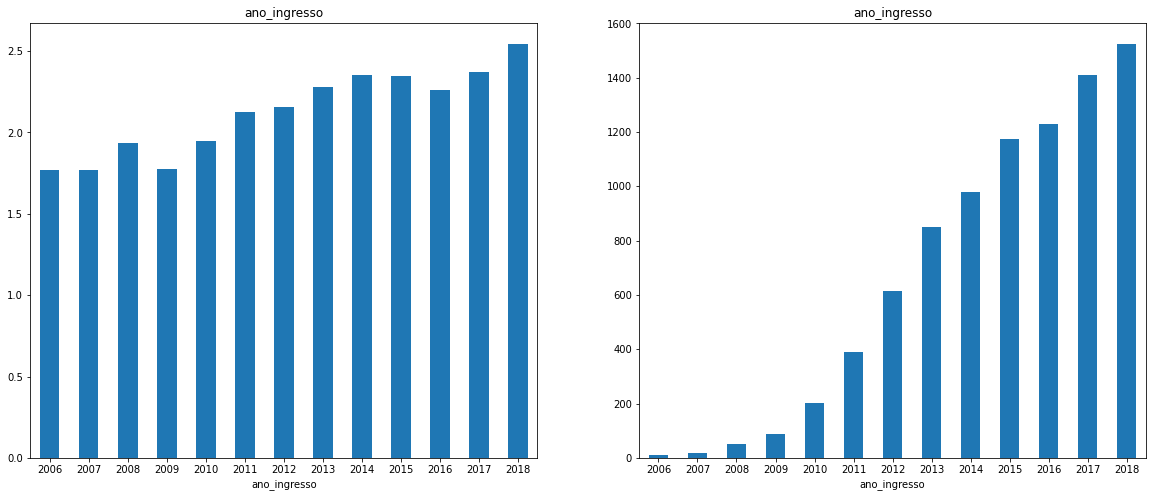

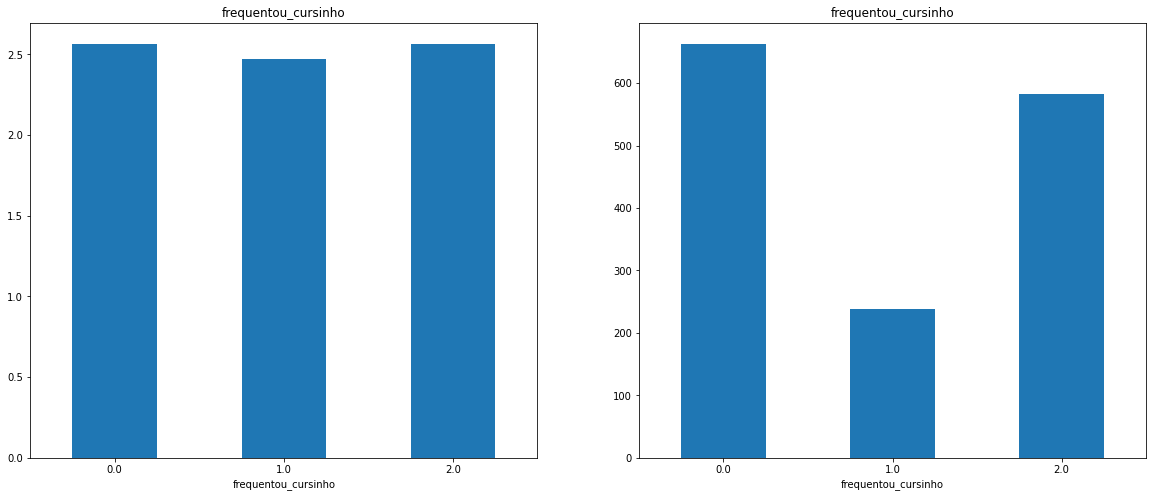

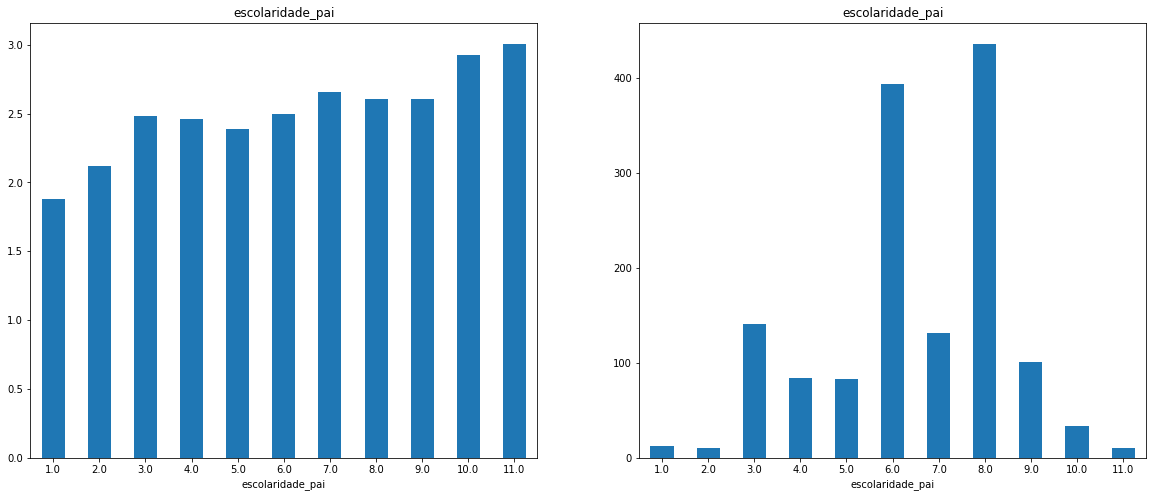

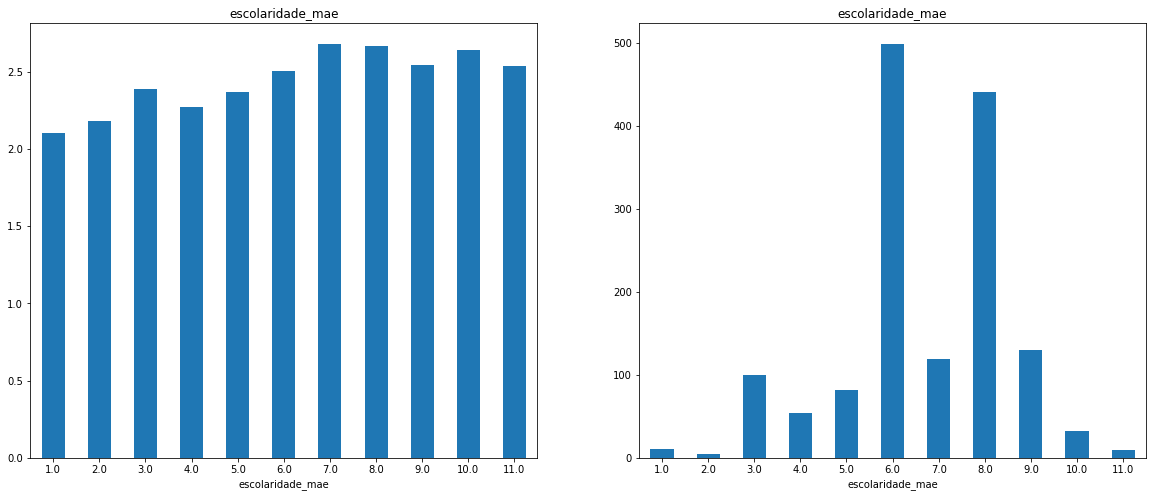

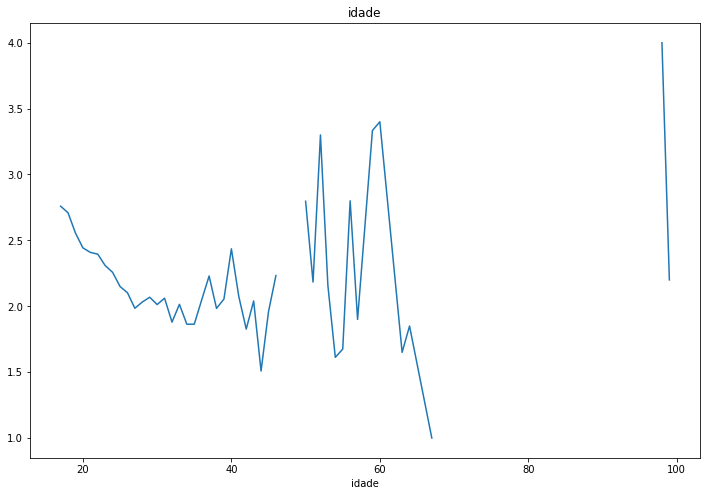

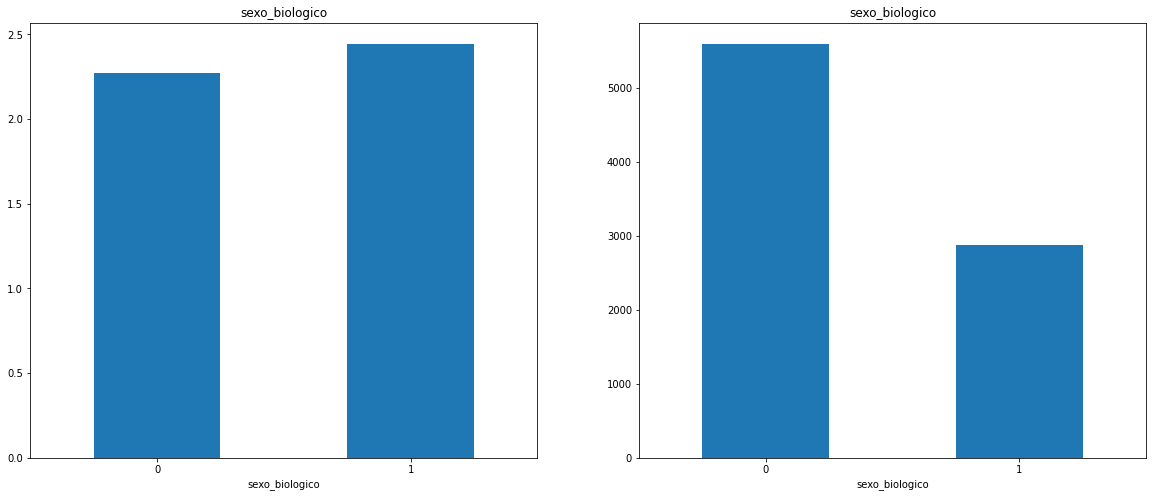

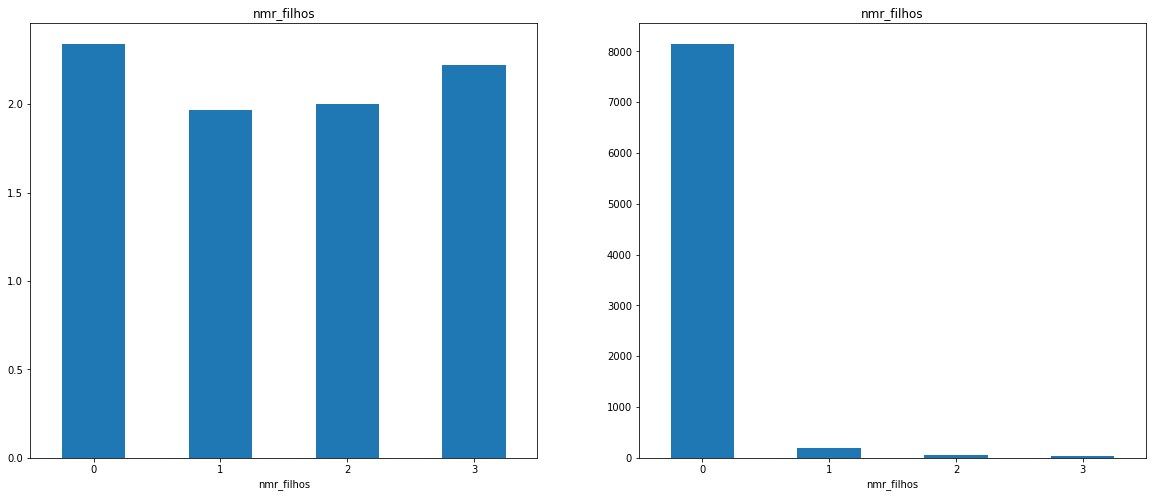

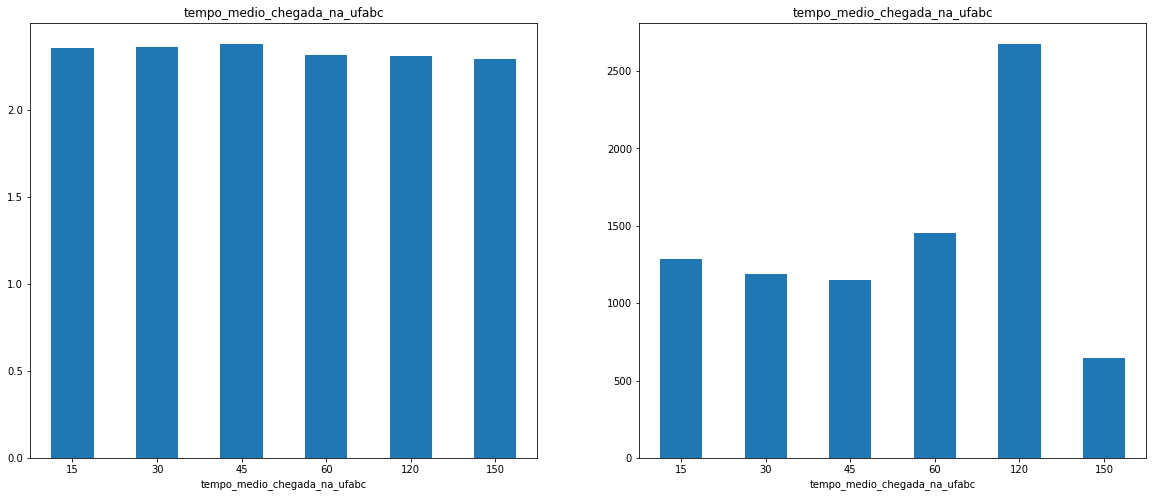

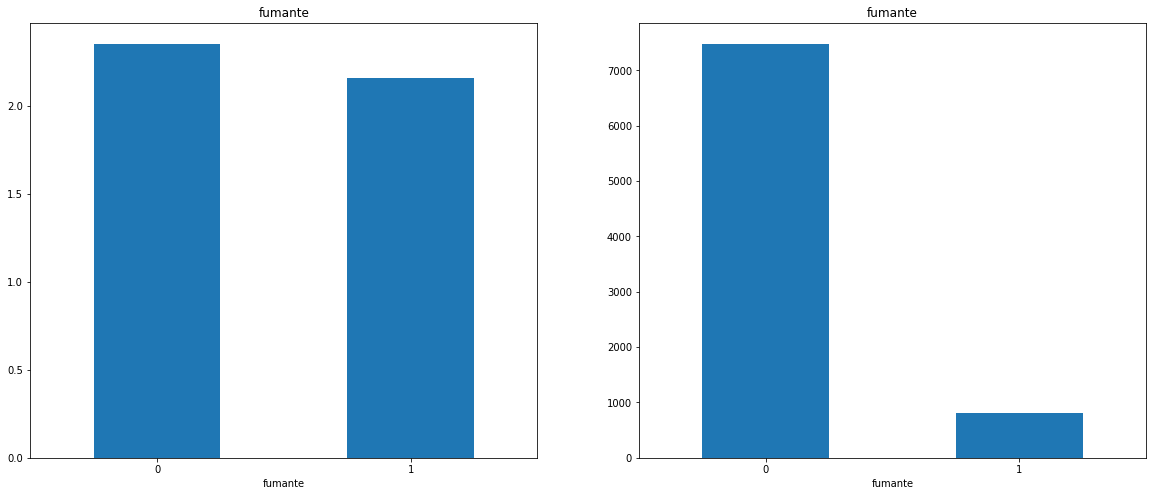

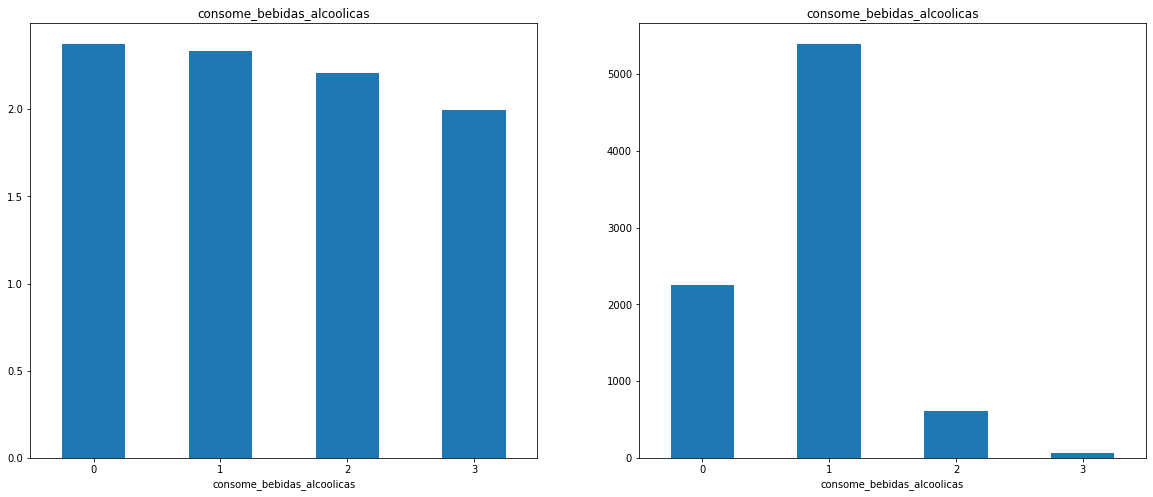

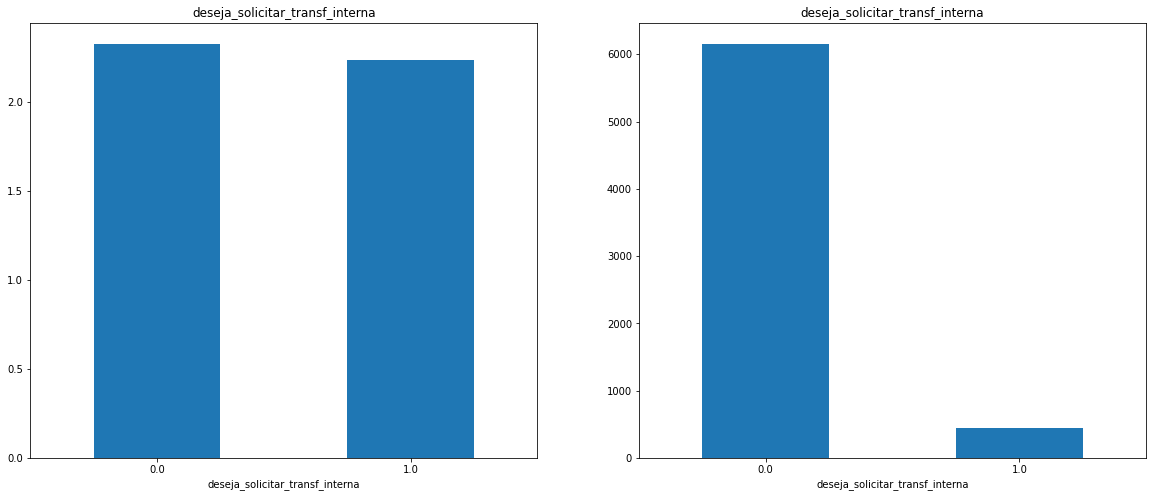

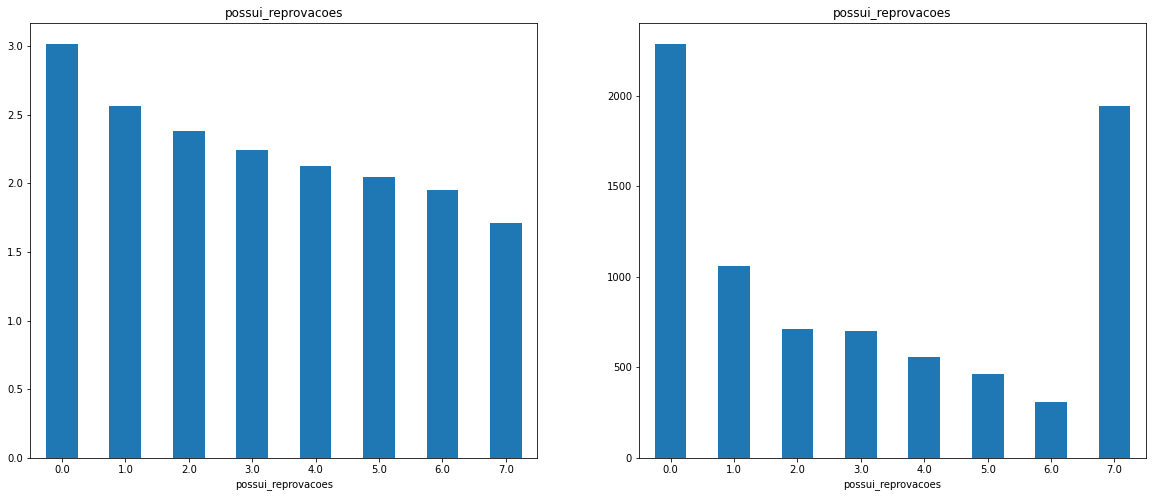

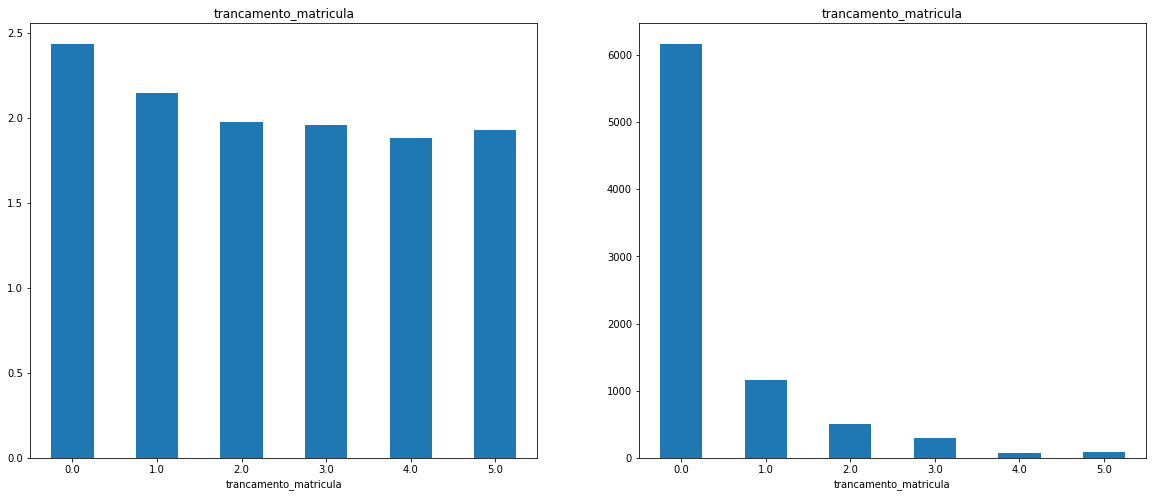

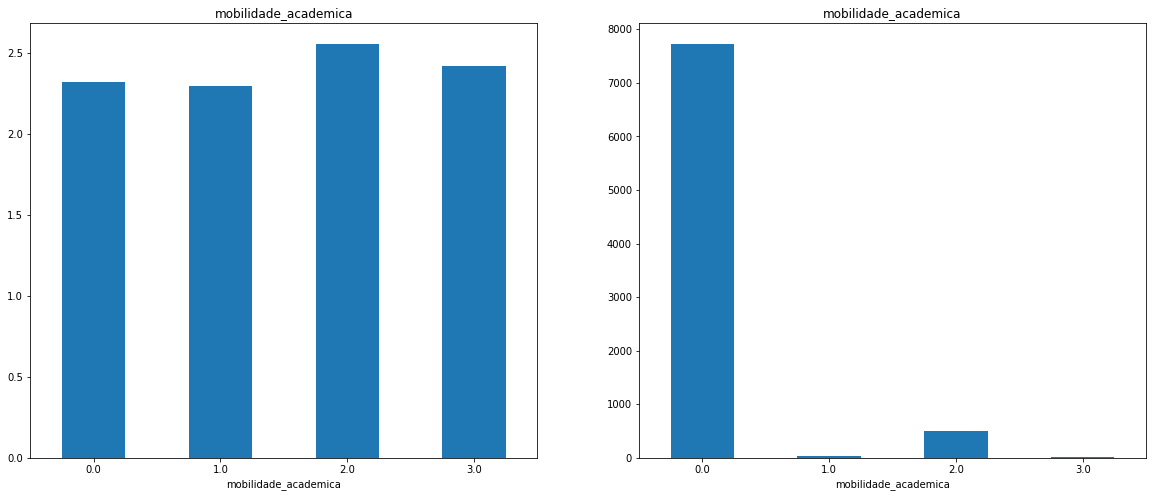

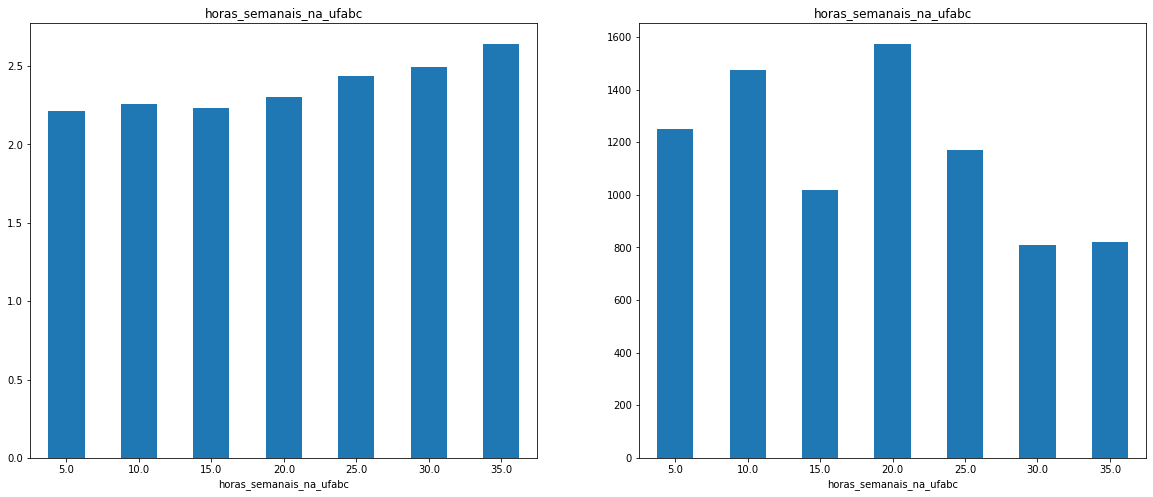

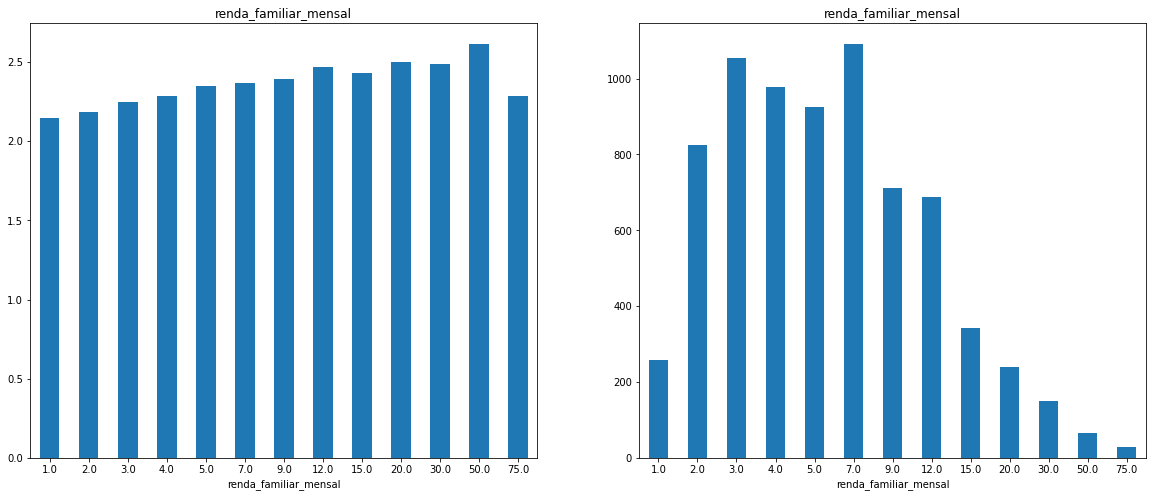

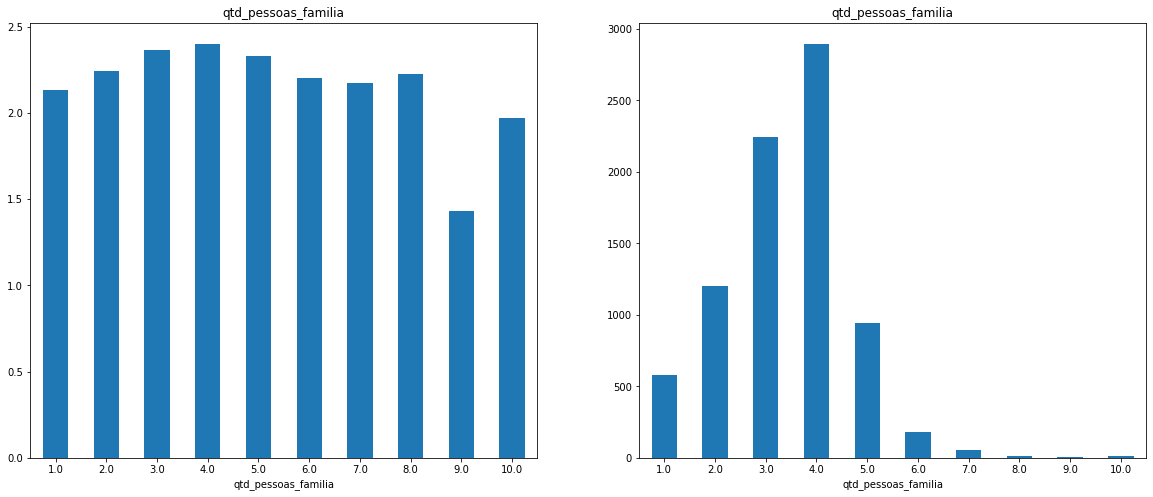

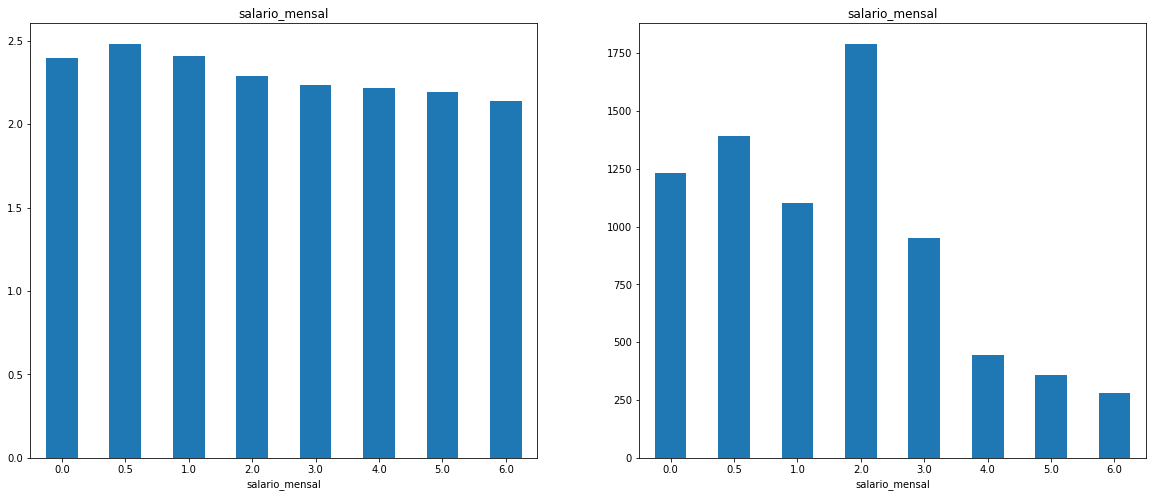

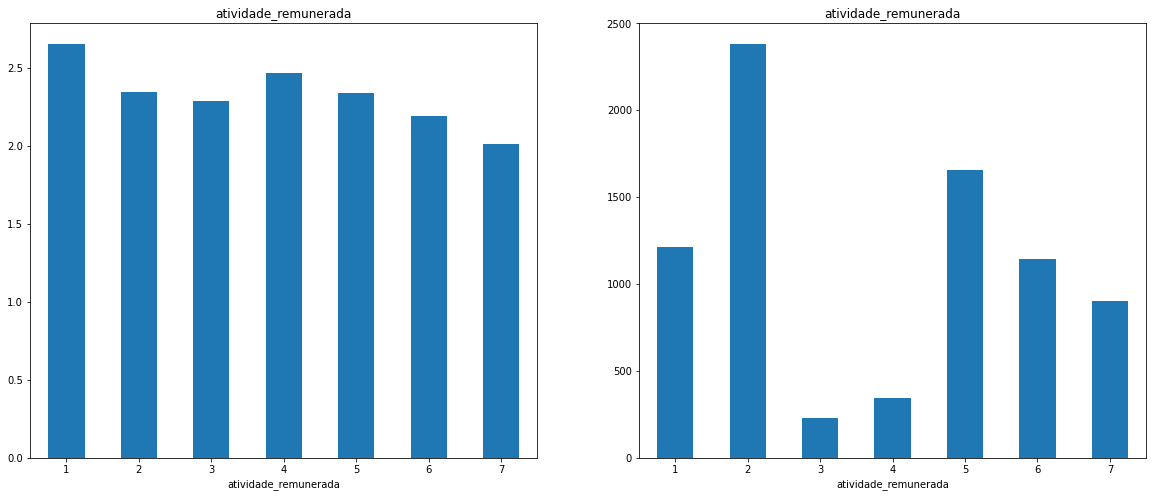

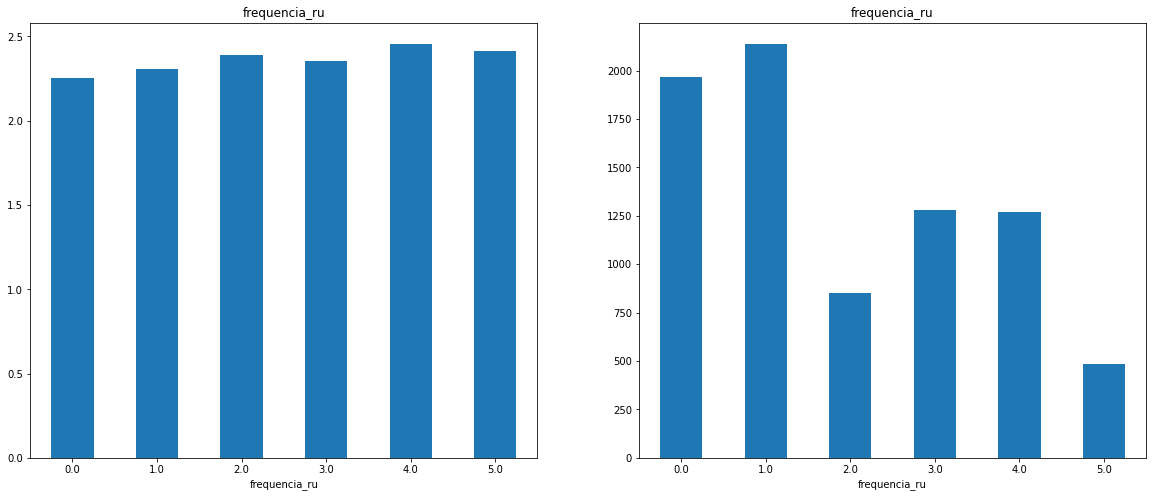

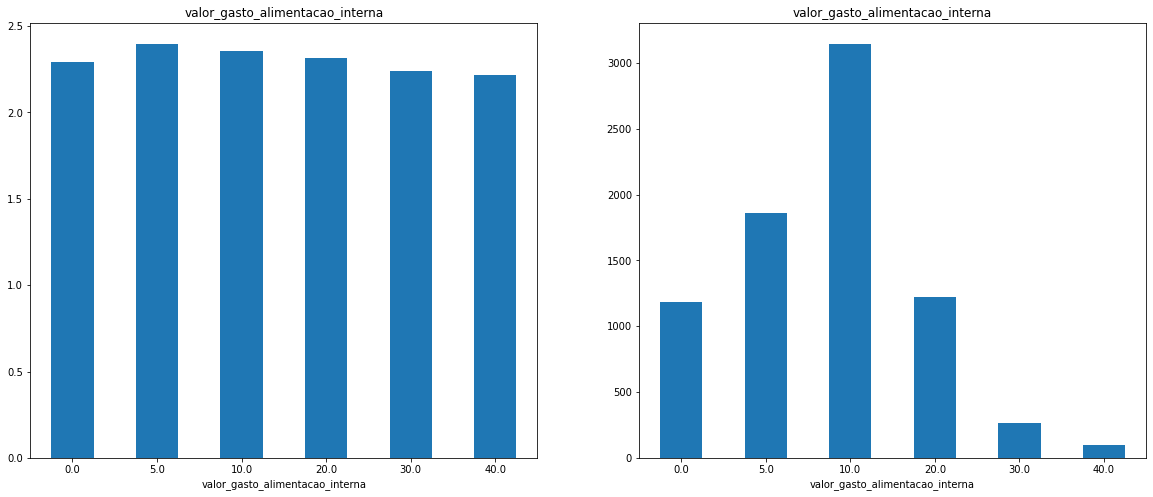

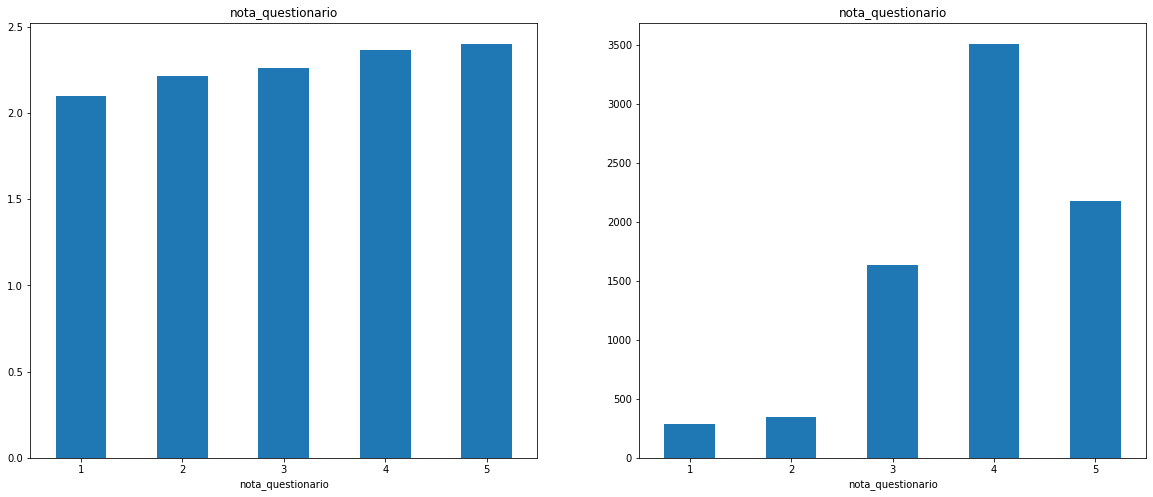

In [56]:
for c in numeric_choice:
    if c!='CR' and c!='CA':
        aux = base_2018_encoded.groupby(c)['CR'].mean()
        aux = aux.loc[aux.index!=-1]
        if(aux.shape[0]<20):
            fig,axs = plt.subplots(figsize=(20,8),ncols=2)
            aux.plot(kind='bar',ax=axs[0],rot=0)
            axs[0].set_title(c)
            
            aux2 = base_2018_encoded.groupby(c)['CR'].count()
            aux2 = aux2.loc[aux2.index!=-1]
            aux2.plot(kind='bar',ax=axs[1],rot=0)
            axs[1].set_title(c)
            
        else:
            fig,axs = plt.subplots(figsize=(12,8))
            aux.plot(kind='line',ax=axs)
            axs.set_title(c)

        #axs.set_ylim(1.5,3.0)
        plt.show()

# Modelos Básicos e estimativas

## Regressão

In [57]:
base_2018_encoded.describe()

,ano_ingresso,frequentou_cursinho,escolaridade_pai,escolaridade_mae,forma_ingresso [Ampla concorrência],forma_ingresso [PEC-G/Transferência Ex Officio/Decisão Judicial],"forma_ingresso [Reserva de vagas (autodeclarado preto, pardo ou indígena)]",forma_ingresso [Reserva de vagas (cursado integralmente o ensino médio em escolas públicas)],forma_ingresso [Reserva de vagas (pessoa com deficiência)],forma_ingresso [Reserva de vagas (refugiado ou solicitante de refúgio - incluindo situação de vulnerabilidade econômica)],"forma_ingresso [Reserva de vagas (renda familiar bruta per capita igual ou inferior a 1,5 salário mínimo)]",forma_ingresso [Transferência externa],forma_ingresso [Prefiro não responder],idade,sexo_biologico,nmr_filhos,meio_transporte [Caminhando (percurso total)],meio_transporte [Caminhando (parte do percurso)],meio_transporte [Bicicleta],meio_transporte [Carona],meio_transporte [Fretado/van],meio_transporte [Metrô],meio_transporte [Ônibus da UFABC],meio_transporte [Transporte particular (carro)],meio_transporte [Transporte particular (moto)],meio_transporte [Uber/taxi],meio_transporte [Trem],meio_transporte [Trólebus/ônibus - exceto ônibus da UFABC],meio_transporte [Prefiro não responder],tempo_medio_chegada_na_ufabc,atividade_extraclasse [Não participo de atividades extraclasse relacionadas à UFABC],atividade_extraclasse [AIESEC],atividade_extraclasse [Atividades culturais],atividade_extraclasse [Atividades de extensão],atividade_extraclasse [Atividades esportivas],atividade_extraclasse [AXIS  Atlética UFABC/CAAP],atividade_extraclasse [Coletivos de cunho religioso],atividade_extraclasse [Coletivos relacionados ao ativismo político],atividade_extraclasse [Coletivos relacionados ao empreendedorismo],atividade_extraclasse [Cursos de idiomas],atividade_extraclasse [DCE/Diretório Acadêmico/Centros Acadêmicos.],atividade_extraclasse [Empresas júniores],atividade_extraclasse [ENACTUS UFABC],atividade_extraclasse [Coletivos LGBTQ+],atividade_extraclasse [Coletivos feministas],atividade_extraclasse [Coletivos étnico-raciais],atividade_extraclasse [GPDA UFABC],atividade_extraclasse [Infanteria UFABC],atividade_extraclasse [Ramo Estudantil IEEE da UFABC],"atividade_extraclasse [Representação discente (ConsUni, ConsEPE, Comissões, etc)]",atividade_extraclasse [UFABC Cheer],atividade_extraclasse [Outras atividades extraclasse (não listadas acima)],atividade_extraclasse [Prefiro não responder],nivel_conhecimento_idioma [Alemão],nivel_conhecimento_idioma [Espanhol],nivel_conhecimento_idioma [Francês],nivel_conhecimento_idioma [Inglês],nivel_conhecimento_idioma [Italiano],nivel_conhecimento_idioma [Japonês],nivel_conhecimento_idioma [Libras],dificuldades [Nenhuma],dificuldades [Acessibilidade nas dependências da UFABC],dificuldades [Assuntos familiares/pessoais],dificuldades [Déficit de formação acadêmica básica],dificuldades [Didática dos docentes],dificuldades [Discriminações e preconceitos],dificuldades [Falta de disciplina/hábito de estudo],dificuldades [Problemas de saúde/psicológicos],dificuldades [Questões financeiras],dificuldades [Questões profissionais],dificuldades [Prefiro não responder],dificuldades_emocionais [Nenhuma],dificuldades_emocionais [Ansiedade],"dificuldades_emocionais [Desânimo, falta de vontade de fazer as coisas]",dificuldades_emocionais [Distúrbios alimentares],"dificuldades_emocionais [Ideia de morte (Pensamentos homicidas, medo da morte, etc)]",dificuldades_emocionais [Medo/pânico],dificuldades_emocionais [Pensamento suicida],dificuldades_emocionais [Sensação de desamparo/desespero/desesperança],dificuldades_emocionais [Sensação de desatenção/desorientação/confusão mental],dificuldades_emocionais [Sentimento de solidão],dificuldades_emocionais [Timidez excessiva],dificuldades_emocionais [Tristeza persistente],dificuldades_emocionais [Prefiro não responder],preconceito_discriminacao [Não],"preconceito_discriminacao [Sim, pela instituição de ensino em que cursei o ensino médio]","preconceito_discrimi

In [58]:
list(base_2018_encoded.columns)

['ano_ingresso',
 'frequentou_cursinho',
 'escolaridade_pai',
 'escolaridade_mae',
 'forma_ingresso [Ampla concorrência]',
 'forma_ingresso [PEC-G/Transferência Ex Officio/Decisão Judicial]',
 'forma_ingresso [Reserva de vagas (autodeclarado preto, pardo ou indígena)]',
 'forma_ingresso [Reserva de vagas (cursado integralmente o ensino médio em escolas públicas)]',
 'forma_ingresso [Reserva de vagas (pessoa com deficiência)]',
 'forma_ingresso [Reserva de vagas (refugiado ou solicitante de refúgio - incluindo situação de vulnerabilidade econômica)]',
 'forma_ingresso [Reserva de vagas (renda familiar bruta per capita igual ou inferior a 1,5 salário mínimo)]',
 'forma_ingresso [Transferência externa]',
 'forma_ingresso [Prefiro não responder]',
 'idade',
 'sexo_biologico',
 'nmr_filhos',
 'meio_transporte [Caminhando (percurso total)]',
 'meio_transporte [Caminhando (parte do percurso)]',
 'meio_transporte [Bicicleta]',
 'meio_transporte [Carona]',
 'meio_transporte [Fretado/van]',
 'me

In [59]:
param_grid ={'alpha':np.arange(0.1,10,0.1)}
lasso_model = Lasso(
    normalize = True,
    max_iter=100000
)
gs = GridSearchCV(
    lasso_model,
    param_grid,
    scoring=make_scorer(r2_score)
)

In [60]:
base_2018_encoded_cr = base_2018_encoded.loc[~base_2018_encoded['CR'].isnull()]
#base_2018_encoded_cr.dropna(inplace=True)

In [61]:
X = base_2018_encoded_cr.drop(['CR','CA'],axis=1).fillna(base_2018_encoded_cr.mean())
y = base_2018_encoded_cr['CR']

In [62]:
gs.fit(X,y)

GridSearchCV(estimator=Lasso(max_iter=100000, normalize=True),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring=make_scorer(r2_score))

In [63]:
gs.best_score_

-0.02578698275871103

In [64]:
rRegressor = Ridge(max_iter=10000,normalize=True)
gs = GridSearchCV(rRegressor,{'alpha':np.arange(0,10,0.1)},scoring=make_scorer(r2_score),cv=3)

In [65]:
gs.fit(X,y)

GridSearchCV(cv=3, estimator=Ridge(max_iter=10000, normalize=True),
             param_grid={'alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
       9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring=make_scorer(r2_score))

In [66]:
gs.best_params_

{'alpha': 0.2}

In [67]:
gs.best_score_

0.4118612417296352

In [68]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [69]:
best = gs.best_estimator_

best.fit(X_train,y_train)

Ridge(alpha=0.2, max_iter=10000, normalize=True)

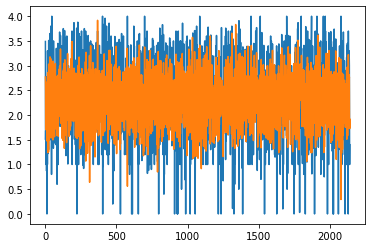

In [70]:
#print(y_test.shape)
plt.plot(y_test.reset_index().drop('index',axis=1))
plt.plot(best.predict(X_test))